# Outline


- [Task 1](#task-1): Multi-class classification with Decision Trees and Random Forests <a name="index-task-1"></a>
  - [(1.1)](#task-11) <a name="index-task-11"></a>
  - [(1.2)](#task-12) <a name="index-task-12"></a>
  - [(1.3)](#task-13) <a name="index-task-13"></a>
  - [(1.4)](#task-14) <a name="index-task-14"></a>
- [Task 2](#task-2): Binary classification with the Huberised Support Vector Machine <a name="index-task-2"></a>
  - [(2.1)](#task-21) <a name="index-task-21"></a>
  - [(2.2)](#task-22)  <a name="index-task-22"></a>
- [Task 3](#task-3): Regression with the Multi-Layer Perceptron <a name="index-task-3"></a>
  - [(3.1)](#task-31) <a name="index-task-31"></a>
  - [(3.2)](#task-32)  <a name="index-task-32"></a>



---



<a name="task-1"></a>

# Task 1: Multi-class classification with Decision Trees and Random Forests  [(index)](#index-task-1)

First, I import packages and set up initial global confiurations for matplotlib as well as setting the seed for rng.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm.notebook import tqdm

# Initial global configuration for matplotlib
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# fixing random generator for reproducibility
rng = np.random.default_rng(0)

# Imports used for testing.
import numpy.testing as npt

Now, I read in the training and test data frames using pandas and print the first five rows to inspect the structure.

In [2]:
# Read in training and test data sets as df_train and df_test
df_train, df_test = pd.read_csv('airfield_statistics_train.csv'), pd.read_csv('airfield_statistics_test.csv')
column_names = df_train.columns
df_train.head()

,Days of airfrost,Precipitation,Sunshine hours,Humidity (%),Wind Speed,Aircraft total movements,Weather and flight condition category,Runway surface minimal temperature,Runway surface maximal temperature
0,24,59.9,58.5,79.3,5.1,1347,3,-2.6,3.8
1,0,66.7,158.3,61.0,3.5,1306,1,11.5,20.0
2,0,39.5,194.6,57.9,3.2,1284,0,8.6,16.8
3,0,34.0,192.8,60.2,2.6,1270,1,12.2,22.4
4,8,17.7,50.3,79.7,2.9,1319,3,2.3,9.5


<a name="task-11"></a>

## (1.1) [(index)](#index-task-11)

In the first part of this section, I define all functions needed to train a decision tree on the training data, predict classifications for the test data using the decision tree and calculate its mean accuracies. I obtain these functions from the notebook on decision trees.

In [3]:
# Calculate the Gini index for the labels in a given region
def gini_index(y):
    """
    Arguments:
        y: vector of training labels, of shape (N,).
    Returns:
        (float): the Gini index for the labels in a given region.
    """

    # Count occurrences of each unique label in y
    unique_labels, counts = np.unique(y, return_counts=True)

    # Compute probabilities for each label
    p = counts / len(y)

    # Compute the sum of squared probabilities
    sum_p_squared = np.sum(p**2)

    # Return Gini Index
    return 1 - sum_p_squared


# Split data according to `value` in `column` returns left (= or <) and right (!= or >=)
def split_samples(X, y, column, value, categorical):
    """
    Return the split of data whose column-th feature:
      1. equals value, in case `column` is categorical, or
      2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        tuple(np.array, np.array, np.array): tuple of the left split data (X_l, y_l).
        tuple(np.array, np.array, np.array): tuple of the right split data (X_l, y_l)
    """

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, split X, y, and sample_weights.
    X_l, y_l = X[left_mask, :], y[left_mask]
    X_r, y_r = X[~left_mask, :], y[~left_mask]

    return (X_l, y_l), (X_r, y_r)


# Calculate minimal Gini index of a split using `column` and gives corresponding threshold
def gini_split_value(X, y, column, categorical):
    """
    Calculate the Gini index based on `column` with the split that minimizes the Gini index.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column index of the feature for calculating. 0 <= column < p
        categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
        (float, float): the resulted Gini index and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Column: {column}."

    gini_index_val, threshold = np.inf, None

    # iterate over all unique values of the i-th feature
    for value in unique_vals:
        # Split the samples into left and right subsets based on the current value
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value, categorical)

        # check if one of the subsets is empty (invalid split)
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        # calculate the proportion of samples on the left and right sides
        p_left = len(y_l)/(len(y_l)+len(y_r))
        p_right = len(y_r)/(len(y_l)+len(y_r))

        # compute the Gini index for the left and right subsets
        new_cost = p_left * gini_index(y_l) + p_right * gini_index(y_r)

        # update the minimum Gini index and the threshold if this split is better
        if new_cost < gini_index_val:
              gini_index_val, threshold = new_cost, value

    return gini_index_val, threshold


# Choose best feature to split and returns minimal Gini index, feature and threshold
def gini_split(X, y, cat_columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimal Gini index found, the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_gini_index = np.inf
    split_column = None
    split_val = np.nan

    for column, categorical in cat_columns_dict.items():
        # skip column if samples are not separable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        gini_index, current_split_val = gini_split_value(X, y, column, categorical)


        if gini_index < min_gini_index:
            # Keep track with:

            # 1. the current minimum gini index value,
            min_gini_index = gini_index

            # 2. corresponding column,
            split_column = column

            # 3. corresponding split threshold.
            split_val = current_split_val

    return min_gini_index, split_column, split_val


# Return most common label in `y`
def majority_vote(y):
    """
    Return the label which appears the most in y.
    Args:
        y: vector of training labels, of shape (N,).
    Returns:
        (int): the majority label
    """
    # Find unique labels and their counts
    labels, counts = np.unique(y, return_counts=True)

    # Identify the label with the maximum count
    majority_label = labels[np.argmax(counts)]

    return majority_label


# Build tree, min samples in leaf = 12
def build_tree(X, y, cat_columns_dict, feature_names, depth, max_depth=10, min_samples_leaf=12):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum depth of the tree.
        min_samples_leaf (int): minimum number of samples in a leaf node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each parent node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same,
    # (iii) depth exceeded, or (iv) X is too small
    if len(np.unique(y))==1 or depth>max_depth or len(X)<=min_samples_leaf:
        return {'majority_label': majority_vote(y)}

    GI, split_index, split_val = gini_split(X, y, cat_columns_dict)

    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'majority_label': majority_vote(y)}

    categorical = cat_columns_dict[split_index]

    # Split samples (X, y, sample_weights) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree(X_l, y_l, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }


# Train data by using build tree
def train(X, y,  cat_columns_dict, max_depth=10):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree(X, y, cat_columns_dict, feature_names, depth=1, max_depth=max_depth)


# Classify single sample `x` using a DT `tree`
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (p,).
    Returns:
        (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None:
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)

    else:

        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify(tree['left'], x)
        else:
            # go to right branch
            return classify(tree['right'], x)
        

# Predict classification of `X` using classify
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])
    

# Use mean accuracy to evaluate how well the tree generalises
def tree_score(tree, X_test, y_test):
    y_pred = predict(tree, X_test)
    return np.mean(y_pred==y_test)

To train the decision tree on the six data features to predict the class label, I split the training and test data into their respective X and y. Then I use `train` to train the decision tree on the training data and `tree_score` to compute and print the training and test accuracy of the decision tree.

In [4]:
# Split the train data into the first 6 columns for X and the 7th column for y
X_train_1 = df_train.iloc[:,:6]
y_train_1 = df_train.iloc[:,6]

# Similarly for the test data
X_test_1 = df_test.iloc[:,:6]
y_test_1 = df_test.iloc[:,6]

# Create dictionary for whether or not columns are categorical,
# in this case all are not categorical
cat_columns_dict_1 = {index: False for index in range(X_train_1.shape[1])}

# Fit the decision tree with training data
tree = train(X_train_1, y_train_1, cat_columns_dict_1)

# Compute the training set and test set mean accuracies using the decision tree
print('Training accuracy:', tree_score(tree, X_train_1.to_numpy(), y_train_1.to_numpy()))
print('Test accuracy:', tree_score(tree, X_test_1.to_numpy(), y_test_1.to_numpy()))

Training accuracy: 0.9281961471103327
Test accuracy: 0.8530612244897959


The proportion of incorrect classifications made by the decision tree on the test data is over twice as large as compared to on the training data, hence it is likely the decision tree is overfitting to the training data which they have a tendency to do. The accuracy on the test data is good at ~$0.853$ however it can be improved on with the implementation of ensemble methods and random forests which will increase generalisability.

To standardise the training and test data I define the function `standardise`, applying it and training a new decision tree on the standardised data. 

In [5]:
# Standardise `X` with values from `X_train`, or `X` if `X_train` unspecified
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True)
    sigma = np.std(X_train_, axis=0, keepdims=True)
    X_std = (X - mu) / sigma
    return X_std

# Standardise the features in the training and test sets
X_train_1_std = standardise(X_train_1.to_numpy())
X_test_1_std = standardise(X_test_1.to_numpy(), X_train_=X_train_1.to_numpy())

# Fit the decision tree with standardised training data
tree_std = train(pd.DataFrame(X_train_1_std, columns=column_names[:6]), y_train_1, cat_columns_dict_1)

# Compute mean accuracies using the new decision tree
print('Training accuracy:', tree_score(tree_std, X_train_1_std, y_train_1.to_numpy()))
print('Test accuracy:', tree_score(tree_std, X_test_1_std, y_test_1.to_numpy()))

Training accuracy: 0.9281961471103327
Test accuracy: 0.8530612244897959


It can be seen that the accuracies for both decision trees are exactly the same on the training and test data frames, hence it appears that standardising the data before training the decision tree does not have an effect on the classifier produced.

In the next part of this section I define functions to be used to train and test a k-Nearest Neighbour (k-NN) classifier that come from the k-NN notebook.

In [6]:
# Calculate the euclidean distance between two vectors or a vector and a matrix of vectors
def euclidean_distance(x_i, x_j):

    '''
    Argument:
    x_i: vector with shape (p,)
    x_j: vector with shape (p,) or matrix with shape (n, p)

    Returns:
    d: distance between x_i and x_j (if both vectors), or between x_i and each row of x_j (if x_j is matrix)
    '''

    assert x_i.shape == x_j.shape or x_j.shape[1] == x_i.shape[0]

    return np.sqrt(np.sum((x_i-x_j)**2, axis=1))


# Find the k nearest neighbours in 'X_train' for every point in 'X_test'
def k_neighbours(X_train, X_test, k=25, return_distance=False):
    """
    This function finds the k nearest neighbours in X_train for each point in X_test.

    Argument:
    X_train: training data
    X_test: test data
    k: number of nearest neighbours
    return_distance: if True, return distances too

    Returns:
    np.array(neigh_ind): array of indices of k nearest neighbours

    """

    n_neighbours = k
    dist = []
    neigh_ind = []

    # compute distance from each point x_test in X_test to all points in X_train
    point_dist = [euclidean_distance(x_test, X_train) for x_test in X_test]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)

    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)

    return np.array(neigh_ind)


# Predict the labels of 'X_test' using k_neighbours and the data 'X_train' and 'y_train'
def predict_k(X_train, y_train, X_test, k=25):
    """
    This function predicts labels of test data given training data and labels.

    Argument:
    X_train: training data
    y_train: training labels
    X_test: test data
    k: number of nearest neighbours

    Returns:
    y_pred: predicted labels for X_test

    """
    # each of the k neighbours contributes equally to the classification of any data point in X_test
    neighbours = k_neighbours(X_train, X_test, k=k)
    # count number of occurences of label with np.bincount and choose the label that has most with np.argmax
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred


# Calculate the mean accuracy of k-Nearest Neighbours on 'X_test', 'y_test' using 'X_train', 'y_train'
# to train the classifier
def k_score(X_train, y_train, X_test, y_test, k=25):

    y_pred = predict_k(X_train, y_train, X_test, k=k)

    return float(sum(y_pred==y_test))/ float(len(y_test))

Now, I use `k_score` to get mean accuracies of k-NN classifier, with $k=25$, on the original and standardised data and print them below.

In [7]:
# Set values of k
k=25

# Print mean accuracies of k-NN using original data
print('Original data:')
print('Training set mean accuracy:', k_score(X_train_1.to_numpy(), y_train_1.to_numpy(), X_train_1.to_numpy(), y_train_1.to_numpy(), k=k))
print('Test set mean accuracy:', k_score(X_train_1.to_numpy(), y_train_1.to_numpy(), X_test_1.to_numpy(), y_test_1.to_numpy(), k=k))

# Print mean accuracies of k-NN using standardised data
print('Standardised data:')
print('Training set mean accuracy:', k_score(X_train_1_std, y_train_1.to_numpy(), X_train_1_std, y_train_1.to_numpy(), k=k))
print('Test set mean accuracy:', k_score(X_train_1_std, y_train_1.to_numpy(), X_test_1_std, y_test_1.to_numpy(), k=k))

Original data:
Training set mean accuracy: 0.6112084063047285
Test set mean accuracy: 0.6040816326530613
Standardised data:
Training set mean accuracy: 0.7968476357267951
Test set mean accuracy: 0.8081632653061225


I see from these mean accuracies that the k-NN classifier with $k=25$ appears to have good generalisability when using both the original and standardised data, as the accuracies of the training and test data sets are around $0.01$ apart. However, there is a large increase in mean accuracy when looking at the classifier using the standardised data compared to the original data, which is due to the standardisation causing all features in the data to be on the same scale, hence preventing certain features from dominating others when calculating the euclidean distance between samples. For example, in the original data, the difference between some entries in the sunshine hours is over $100$, whereas the difference in the wind speed is never as large and is frequently as small as $2$.

The mean accuracies of the decision tree classifier (on both original and standardised data sets since the accuracies are equal) are greater than the k-NN classifier on both original and standardised data sets. Although the decision tree classifier does have a lower mean accuracy on the test set compared to the training set and appears to lack some generalisability, it does still have a greater mean accuracy than the k-NN classifier, which appears to have better generalisability.

Finally, to explain the exact same mean accuracies of the decision tree classifiers from the original and standardised data sets it is useful to consider how they work in practice. Since all samples in the training and test sets are standardised using the same mean and standard deviation, I see that given some threshold value $s$, if I apply the same standardisation to $s$, the samples that had feature $j$ less than $s$ will also have their standardised value of feature $j$ less than the standardised $s$ and vice versa. Hence, one can see that such a standardisation will have no effect on the way the decision tree is formed apart from the values of $s$ will be standardised, hence the classifiers have the same mean accuracies.

<a name="task-12"></a>

## (1.2) [(index)](#index-task-12)

In this section, I define functions to train a decision tree that can be used to give a vector of probabilities that the sample belongs to each of the four classes. To do this I implement a function `proba_label` and then alter `build_tree`, `train`, `classify` and `predict` to give four new functions `build_tree_soft`, `train_soft`, `classify_soft` and `predict_soft` that allow me to train a decision tree in this way.

In [8]:
# Calculate the proportion of each label in the vector y
def proba_label(y):
    """
    Return the proportion of each label in y.
    Args:
        y: vector of training labels, of shape (N,).
    Returns:
        (int): the proportion of each label.
    """
    # Find counts of each label
    counts = np.bincount(y, minlength=4)[:4]
        

    # Create array of probabilities of 0, 1, 2, 3 respectively
    proba_label = counts/np.sum(counts)

    return proba_label


# Altered build_tree, where leaf nodes contain proportion of each label
def build_tree_soft(X, y, cat_columns_dict, feature_names, depth, max_depth=10, min_samples_leaf=12):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum depth of the tree.
        min_samples_leaf (int): minimum number of samples in a leaf node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each parent node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'proba_label': For leaf nodes, this stores the probability of each label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same,
    # (iii) depth exceeded, or (iv) X is too small
    if len(np.unique(y))==1 or depth>max_depth or len(X)<=min_samples_leaf:
        return {'proba_label': proba_label(y)}

    GI, split_index, split_val = gini_split(X, y, cat_columns_dict)

    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'proba_label': proba_label(y)}

    categorical = cat_columns_dict[split_index]

    # Split samples (X, y, sample_weights) given column, split-value, and categorical flag.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val, categorical)
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'proba_label': None,
        'left': build_tree_soft(X_l, y_l, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree_soft(X_r, y_r, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }


# Train data by using build_tree_soft
def train_soft(X, y,  cat_columns_dict, max_depth=10):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        sample_weights: weights for each samples, of shape (N,).
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree_soft(X, y, cat_columns_dict, feature_names, depth=1, max_depth=max_depth)


# Give probabilities of each label for a single sample `x` using a DT `tree`
def classify_soft(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (p,).
    Returns:
        (int): predicted probabilities of each label.
    """
    if tree['proba_label'] is not None:
        return tree['proba_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            # go to left branch
            return classify_soft(tree['left'], x)
        else:
            # go to right branch
            return classify_soft(tree['right'], x)

    else:

        if x[tree['feature_index']] < tree['value']:
            # go to left branch
            return classify_soft(tree['left'], x)
        else:
            # go to right branch
            return classify_soft(tree['right'], x)
        

# Predict probabilities of each label of each sample in `X` using classify_soft
def predict_soft(tree, X):
    """
    Predict classification results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted probabilities of labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify_soft(tree, X)
    else:
        return np.array([classify_soft(tree, x) for x in X])

I now train the decision tree on the training set and use this to predict the probabilities for the training and test sets. Also, I calculate the mean probability of correct classifications on the training and test sets.

In [9]:
# Mean probability of classifying test sample as correct 
tree_soft = train_soft(X_train_1, y_train_1, cat_columns_dict_1)
y_pred_soft_train = predict_soft(tree_soft, X_train_1.to_numpy())
y_pred_soft_test = predict_soft(tree_soft, X_test_1.to_numpy())
prob_sum_train, prob_sum_test = 0, 0
for i in range(len(y_train_1)):
    prob_sum_train += y_pred_soft_train[i][y_train_1[i]]
for i in range(len(y_test_1)):
    prob_sum_test += y_pred_soft_test[i][y_test_1[i]]

print('Mean probability of classifying training set correctly:', prob_sum_train/len(y_train_1))
print('Mean probability of classifying test set correctly:', prob_sum_test/len(y_test_1))   

Mean probability of classifying training set correctly: 0.9006219310947858
Mean probability of classifying test set correctly: 0.8137242689283506


By summing up the probabilities that the soft classifier gives of correctly classifying the training and test sets and dividing this by the respective numbers of samples, I see that the mean probability of correct classifications on the training set is ~0.901 and the mean probability of correct classifications on the test set is ~0.814. Similarly to the decision tree for hard classifications, the decision tree for soft classifications performs worse on the test set than on the training set indicating a lack of generalisability but still has a good mean probability of correct classifications on the test set.

To evaluate the decision tree's probabilistic predictions on the test set, and assess the DT’s ability to discriminate between pairs of classes I consider only the probabilistic predictions for each pair and draw the corresponding Receiver Operating Characteristic (ROC) curves as well as calculating the area under each one.

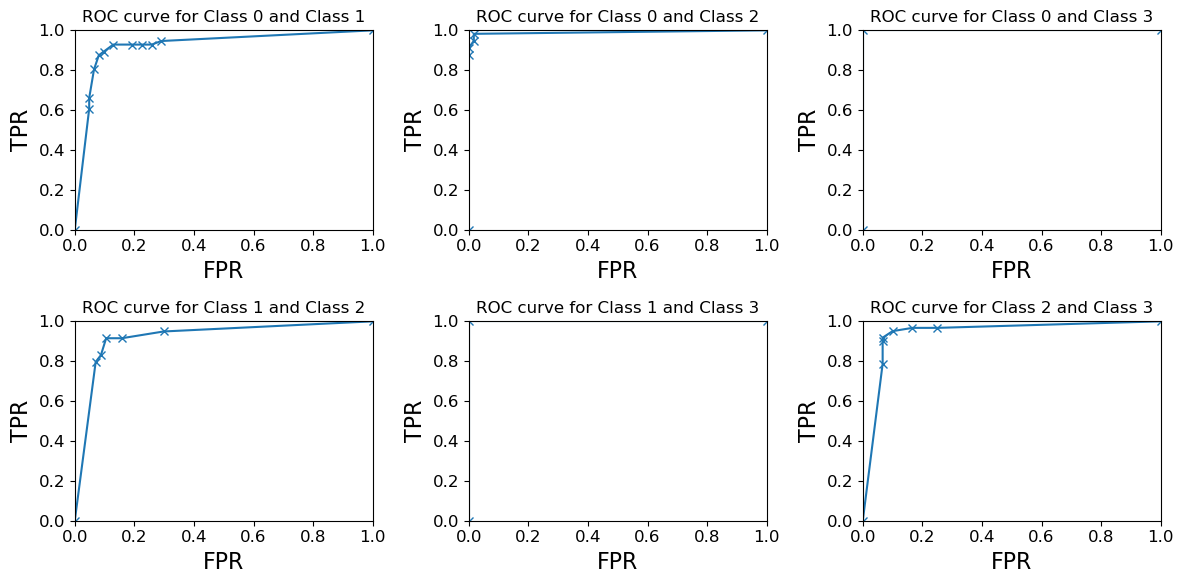

Area under ROC curve for classes 0 and 1: 0.9243951612903226
Area under ROC curve for classes 0 and 2: 0.9901873327386262
Area under ROC curve for classes 0 and 3: 1.0
Area under ROC curve for classes 1 and 2: 0.9204579244721973
Area under ROC curve for classes 1 and 3: 1.0
Area under ROC curve for classes 2 and 3: 0.9396174863387977


In [10]:
# Initialise lists to store lists of the true and false positive rates for each pair of classes
TPR_list, FPR_list = [], []

# Loop over each pair of classes i and j
for i in range(3):
    for j in range(i+1, 4):
        # Find indexes of test samples with y equal to i or j
        index_ij = y_test_1.index[y_test_1.isin([i, j])].tolist()
        y_test_1_ij = y_test_1.to_numpy()[index_ij]
        
        # Make y_pred_ij of probabilities of such samples being i or j from our predictions
        y_pred_ij = y_pred_soft_test[index_ij][:,[i, j]]
        
        # Remove rows that have zero probability of being in i or j, make sums of probabilities
        # equal to 1
        row_sums_ij = y_pred_ij.sum(axis=1)
        y_pred_ij = y_pred_ij[row_sums_ij!=0]/y_pred_ij.sum(axis=1,keepdims=True)[row_sums_ij!=0]
        y_test_1_ij = y_test_1_ij[row_sums_ij!=0]
        
        # Store the unique probabilities of being class j
        unique_probs = np.unique(y_pred_ij[:,1])
        
        # Calculate the number of samples belonging to class j in T and class i in F
        T, F = (y_test_1_ij == j).sum(), (y_test_1_ij == i).sum()
        
        # Initialise lists TPR and FPR each with 0 in to store the true and false positive rates
        # for classes i and j
        TPR, FPR = [0], [0]
        
        # Loop over each unique probability and calculate the TPR and FPR of using each probability as
        # the requirement to classify a sample as class j
        for prob in unique_probs[::-1]:
            x, y = 0, 0
            # Loop over each sample and add a count to y or x if it is a true positive or false positive
            # respectively
            for k in range(T+F):
                if (y_pred_ij[k, 1] >= prob) and (y_test_1_ij[k] == j):
                    y += 1
                elif (y_pred_ij[k, 1] >= prob) and (y_test_1_ij[k] == i):
                    x += 1
            TPR.append(y/T)
            FPR.append(x/F)
        
        # Append TPR and FPR to their respective lists
        TPR_list.append(TPR)
        FPR_list.append(FPR)
  

# Plots of ROC curve for each pair of classes
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

axs[0, 0].plot(FPR_list[0], TPR_list[0], marker='x')
axs[0, 0].set_title('ROC curve for Class 0 and Class 1')
axs[0, 0].set_xlim(0, 1)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlabel('FPR')
axs[0, 0].set_ylabel('TPR')

axs[0, 1].plot(FPR_list[1], TPR_list[1], marker='x')
axs[0, 1].set_title('ROC curve for Class 0 and Class 2')
axs[0, 1].set_xlim(0, 1)
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xlabel('FPR')
axs[0, 1].set_ylabel('TPR')

axs[0, 2].plot(FPR_list[2], TPR_list[2], marker='x')
axs[0, 2].set_title('ROC curve for Class 0 and Class 3')
axs[0, 2].set_xlim(0, 1)
axs[0, 2].set_ylim(0, 1)
axs[0, 2].set_xlabel('FPR')
axs[0, 2].set_ylabel('TPR')

axs[1, 0].plot(FPR_list[3], TPR_list[3], marker='x')
axs[1, 0].set_title('ROC curve for Class 1 and Class 2')
axs[1, 0].set_xlim(0, 1)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlabel('FPR')
axs[1, 0].set_ylabel('TPR')

axs[1, 1].plot(FPR_list[4], TPR_list[4], marker='x')
axs[1, 1].set_title('ROC curve for Class 1 and Class 3')
axs[1, 1].set_xlim(0, 1)
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xlabel('FPR')
axs[1, 1].set_ylabel('TPR')

axs[1, 2].plot(FPR_list[5], TPR_list[5], marker='x')
axs[1, 2].set_title('ROC curve for Class 2 and Class 3')
axs[1, 2].set_xlim(0, 1)
axs[1, 2].set_ylim(0, 1)
axs[1, 2].set_xlabel('FPR')
axs[1, 2].set_ylabel('TPR')
      
plt.tight_layout()
plt.show()

# Calculate area under each ROC curve and append to areas
areas = []
for i in range(6):
    areas.append(np.trapz(TPR_list[i], FPR_list[i]))

# Print the area under each ROC curve
print('Area under ROC curve for classes 0 and 1:', areas[0])
print('Area under ROC curve for classes 0 and 2:', areas[1])
print('Area under ROC curve for classes 0 and 3:', areas[2])
print('Area under ROC curve for classes 1 and 2:', areas[3])
print('Area under ROC curve for classes 1 and 3:', areas[4])
print('Area under ROC curve for classes 2 and 3:', areas[5])

From the plots of the ROC curves and the respective areas under these curves, I see that the pair of classes that the decision tree has weakest ability to discriminate between is $1$ and $2$. The pair that the decision tree has next weakest ability to discriminate between is $0$ and $1$, followed by $2$ and $3$. In the context of the data, this conclusion seems logical as these three pairs are the pairs that are only one condition apart and hence will likely share similar values in the six features. $0$ and $2$ have almost an area of $1$ under their ROC curve, and the pairs $0$ and $3$ and $1$ and $3$ have an area of one under their curves. Again this is logical as these pairs represent weather and flight conditions that are less comparable. From the plots, I see that with all pairs of classes $i$ and $j$, $i < j$, I can find a probability of being class $j$ to require to classify the samples as class $j$ so that the true positive rate is at least 0.9 and the false positive rate is less than 0.15. From this I conclude that the decision tree is good at discriminating between all pairs of classes, and the bigger the difference between conditions, the better the decision tree can discriminate between them.

<a name="task-13"></a>

## (1.3) [(index)](#index-task-13)

In this section, I will modify functions from the random forests notebook to be used in training a random forest and computing the Gini importances of each of the six features. To train a random forest I will perform bagging with bootstrapped samples of size $N' = N^{train}$ and randomly sample $m = \sqrt{p} = \sqrt{6} \approx 3$ of the features at each split.

In [11]:
# New gini_split function with random sampling of `n_features`
def gini_split_rf(n_features, X, y, cat_columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
        (float, int, float): the minimized gini index, the best feature index and value used in splitting.
    """

    # The added sampling step.
    columns = rng.choice(list(cat_columns_dict.keys()), n_features, replace=False)
    cat_columns_dict = {c: cat_columns_dict[c] for c in columns}

    min_gini_index, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `cat_columns_dict`.
    for column, categorical in cat_columns_dict.items():
        # skip column if samples are not separable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        gini_index, val = gini_split_value(X, y, column, categorical)
        if gini_index < min_gini_index:
            min_gini_index, split_column, split_val = gini_index, column, val

    return min_gini_index, split_column, split_val


# New build_tree function for random forest training using the new gini_split_rf function with each non-leaf 
# node also containing GI_decrease and Nt keys
def build_tree_rf(n_features, X, y, cat_columns_dict, feature_names, depth,  max_depth=10, min_samples_leaf=12):
    """Build the decision tree according to the data.
    Args:
        n_features: number of sampled features.
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
        max_depth (int): maximum depth of the tree.
        min_samples_leaf (int): minimum number of samples in a leaf node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'GI_decrease': The value of Gini index decrease for current node.
          5. 'Nt': The number of samples.
          6. 'categorical': indicator for categorical/numerical variables.
          7. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          8. 'left': The left sub-tree with the same structure.
          9. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all labels are the same, (ii) depth exceeded (iii) X is too small
    if len(np.unique(y)) == 1 or depth>max_depth or len(X)<=min_samples_leaf:
        return {'majority_label': majority_vote(y)}

    else:
        GI, split_column, split_val = gini_split_rf(n_features, X, y, cat_columns_dict)

        # If GI is infinity, it means that samples are not separable by the sampled features.
        if GI == np.inf:
            return {'majority_label': majority_vote(y)}
        categorical = cat_columns_dict[split_column]
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val, categorical)
        GI_decrease = gini_index(y) - GI
        Nt = len(y)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'GI_decrease': GI_decrease,
            'Nt': Nt,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, cat_columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }
    

# Define train_rf to return a list of B decision trees using build_tree_rf
def train_rf(B, n_features, X, y, cat_columns_dict, max_depth=10):
    """
    Resample B datasets from the training data and build a decision tree for each of them.
    Args:
        B: number of decision trees.
        n_features: number of sampled features.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        max_depth (int): maximum depth of each tree.
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = rng.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample,
                        cat_columns_dict, feature_names, depth=1, max_depth=max_depth)
        trees.append(tree)

    return trees


# Traverse 'tree' to return defaultdict sum_GI_decrease of weighted sum of GI_decrease values at each node
# split into each feature
def tree_GI_decrease(tree):
    """
    This function uses recursion to sum GI_decrease values, weighted by the proportion of samples
    in that node, for each feature in the input tree and returns these weighted sums in a defaultdict.
    """
    sum_GI_decrease = defaultdict(float)
    N = tree['Nt']
    
    def traverse(node):
        if not node:  # Base case: empty node
            return
        
        if ('GI_decrease' in node) and ('feature_name' in node) and (node['majority_label'] is None):
            sum_GI_decrease[node['feature_name']] += (node['Nt']/N)*node['GI_decrease']
        
        # Recursively traverse left and right subtrees
        traverse(node.get("left"))
        traverse(node.get("right"))
    
    traverse(tree)
    return sum_GI_decrease


# Use tree_GI_decrease for each tree in 'forest' to compute Gini importance of each feature
# and return defaultdict 'gini_importance' containing Gini importances as a percentage of
# the max Gini importance
def forest_GI_importance(forest):
    """
    This function uses tree_GI_decrease on all trees in the input forest and averages the weighted sums
    of Gini index decreases for each feature giving their Gini importances and returns a defaultdict
    containing these Gini importances as a percentage of the max Gini importance.
    """
    B = len(forest)
    gini_importance = defaultdict(float)
    
    for tree in forest:
        sum_GI_decrease = tree_GI_decrease(tree)
        for feature, sum_ in sum_GI_decrease.items():
            gini_importance[feature] += sum_/B
    
    max_importance = max(gini_importance.values())
    for feature, importance in gini_importance.items():
        gini_importance[feature] = (importance/max_importance)*100
    
    return gini_importance

Now I use `train_rf` and `forest_GI_importance` to train a random forest, with $m = \sqrt{p} = \sqrt{6} \approx 3$ as recommended for classification, on our training set and compute the Gini importances of each feature in our data using the formula: 
$$\text{Gini importance }(x_k) = \frac{1}{B} \sum_{b=1}^{B} \sum_{t \in T: j_t = k} \frac{N^t}{N'} \Delta GI(s_t, t),$$
where the decrease in Gini index is given by $\Delta GI(s_t, t) = (GI(t) - p_l GI(t_l) - p_r GI(t_r))$ and $N_t$ is the number of training samples reaching the node $t$ in the tree $T_b$. $GI(t)$ is the Gini index before the split, $GI(t_l)$ and $GI(t_r)$ are the Gini indexes are the split on the left and right respectively and $p_l$ and $p_r$ are the proportions of the training samples at node $t$ that go to the left and right respectively. Then I plot the importances of these features as a percentage of the maximum importance.

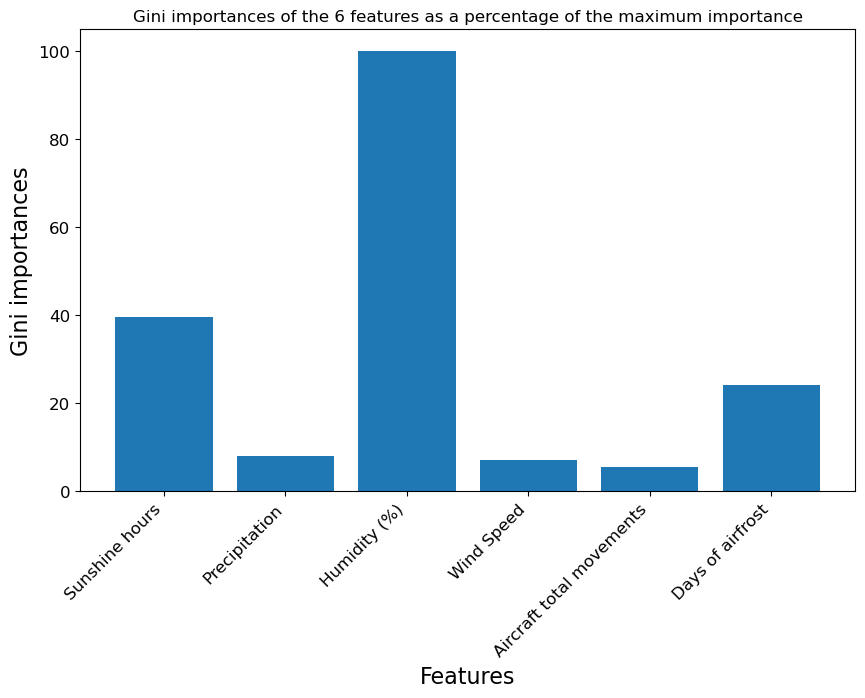

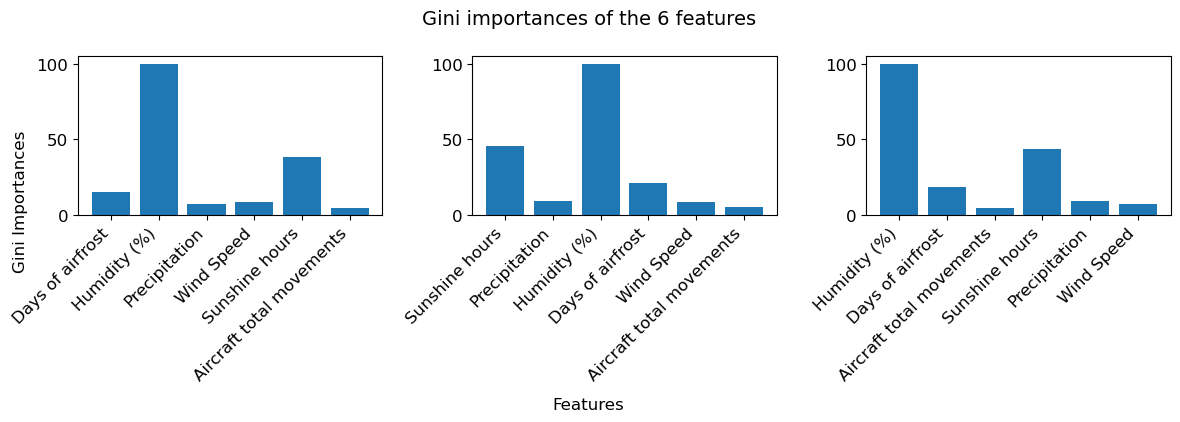

In [12]:
# Train the random forest using train_rf with B = 20 and m = 3
forest = train_rf(20, 3, X_train_1, y_train_1, cat_columns_dict_1, max_depth=10)

# Create lists of the feature names and their respective Gini importances
features_forest, gini_importances = [], []
for key, value in forest_GI_importance(forest).items():
    features_forest.append(key)
    gini_importances.append(value)

# Plot Gini importances of the features
plt.figure(figsize=(10,6))
plt.bar(features_forest, gini_importances)
plt.xticks(rotation=45, ha="right")
plt.title('Gini importances of the 6 features as a percentage of the maximum importance')
plt.xlabel('Features')
plt.ylabel('Gini importances')
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

for i in range(3):
    forest = train_rf(20, 3, X_train_1, y_train_1, cat_columns_dict_1, max_depth=10)
    features_forest, gini_importances = [], []
    for key, value in forest_GI_importance(forest).items():
        features_forest.append(key)
        gini_importances.append(value)
    axs[i].bar(features_forest, gini_importances)
    axs[i].set_xticks(range(len(features_forest)))
    axs[i].set_xticklabels(features_forest, rotation=45, ha="right")

fig.suptitle('Gini importances of the 6 features', fontsize=14)
fig.text(0.5, -0.02, 'Features', ha='center', fontsize=12)
fig.text(0.02, 0.5, 'Gini Importances', va='center', rotation='vertical')
plt.tight_layout()
plt.show()

From the first plot, I conclude that humidity is the most important feature with the next most important feature sunshine hours at 40% of the importance of humidity. The remaining features are even less important with aircraft total movements having around 1/10th of the importance of humidity. Contextually, it can be seen that these importances do somewhat reflect the importances of these features on the weather and flight conditions, as a high humidity will decrease air density and can significantly affect the flight conditions, hence making it the most important of the six features by a considerable margin. From the three subplots underneath, it can be seen that although the percentages do vary when new random forests are generated, they do not vary by much and the order of importances is always the same with exception of some of the features with very little importance such as precipitation and wind speed. This implies that although there is an element of randomness in the generation of the random forests, they consistently favour certain features over others, where possible.

<a name="task-14"></a>

## (1.4) [(index)](#index-task-14)

In this section, I modify the `train_rf` function, define some other functions: `aggregate`, `predict_rf` and `rf_score` from the random forest notebook and define a new function `OOB_error` to calculate Out-of-Bag (OOB) misclassification error for a given random forest. This is done by editing the `train_rf` function to now return not only the list of trees in the random forest but also a defaultdict which contains items consisting of every sample index from the training set as keys, each having a list of the indexes of the trees that they are an OOB sample for, as their value. The function `OOB_error` then takes both outputs of `train_rf` as well as the X and y the random forest was trained on as inputs and computes for each sample whether or not the trees in the random forest for which the sample is OOB for predicts its label correctly. It then returns the proportion of samples that are correctly classified in this way.

In [13]:
# Alter train_rf to give train_rf_OOB which returns a random forest and a defaultdict OOB_dict of
# each sample index as the keys and the value of each key the index of trees of which the sample
# is an OOB sample for
def train_rf_OOB(B, n_features, X, y, cat_columns_dict, max_depth=10):
    """
    Resample B datasets from the training data and build a decision tree for each of them.
    Args:
        B: number of decision trees.
        n_features: number of sampled features.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
        cat_columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
        max_depth (int): maximum depth of each tree.
    """

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []
    
    OOB_dict = defaultdict(list)
    
    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = rng.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample,
                        cat_columns_dict, feature_names, depth=1, max_depth=max_depth)
        trees.append(tree)
        for n in training_indices:
            if n not in sample:
                OOB_dict[n].append(_)
        
    return trees, OOB_dict


# Aggregate over all trees
def aggregate(decisions):
    """
    This function takes a list of predicted labels produced by a list
    of decision trees and returns the label with the majority of votes.
    """
    count = defaultdict(int)
    for decision in decisions:
        count[decision] += 1
    return max(count, key=count.get)


# Use aggregate to predict sample labels using the random forest 'rf'
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    if len(X.shape) == 1:
        # if we have one sample
        return aggregate([classify(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

    
# Compute the mean accuracy of 'rf' on 'X_test' using 'y_test' to check each prediction
def rf_score(rf, X_test, y_test):
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)


# Compute the OOB error for a list of 'trees' using 'OOB_dict' and the training data 'X_train' and 'y_train'
def OOB_error(trees, OOB_dict, X_train, y_train):
    scores = []
    for n in OOB_dict:
        scores.append(rf_score([trees[i] for i in OOB_dict[n]], X_train.iloc[n, :], y_train.iloc[n]))
    
    return 1 - sum(scores)/len(scores)

For $B \in \{2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50 \}$, I compute the OOB error of a random forest with $B$ trees using `train_rf_OOB` and plot these against B to find the optimal in this set.

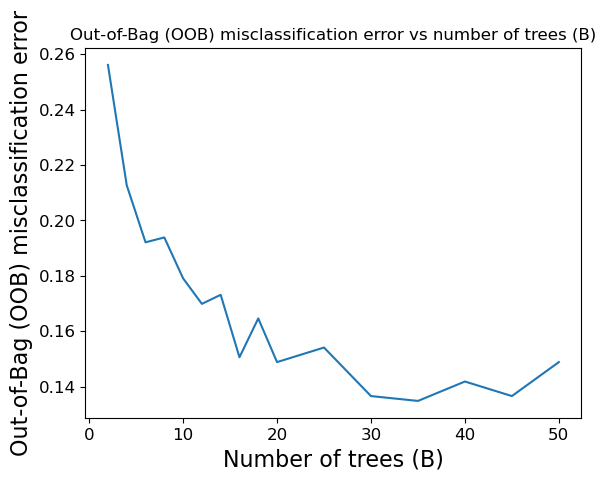

In [14]:
# Create list of possible values for B
B_list = [2*i for i in range(1, 11)] + [25, 30, 35, 40, 45, 50]
OOB_errors = []

for B in B_list:
    trees, OOB_dict = train_rf_OOB(B, 3, X_train_1, y_train_1, cat_columns_dict_1, max_depth=10)
    OOB_errors.append(OOB_error(trees, OOB_dict, X_train_1, y_train_1))
    
plt.plot(B_list, OOB_errors)
plt.title('Out-of-Bag (OOB) misclassification error vs number of trees (B)')
plt.xlabel('Number of trees (B)')
plt.ylabel('Out-of-Bag (OOB) misclassification error')
plt.show()

From the above plot of OOB misclassification errors against the number of trees in the random forests, the optimal value of B is seen to be 35. Not only is this where the OOB error is the lowest from the values of B I experimented over, but it is also less than other values of B such as 45 and 50 where the OOB error is close but will require more work to create the random forest.

In [15]:
# Train a new random forest with 35 trees and compute its mean accuracy on the test set
forest_35 = train_rf(35, 3, X_train_1, y_train_1, cat_columns_dict_1, max_depth=10)
print('Test accuracy:', rf_score(forest_35, X_test_1.to_numpy(), y_test_1.to_numpy()))

Test accuracy: 0.9020408163265307


When using 35 trees in a random forest, I observe an increase in accuracy on the test set compared to that of a single decision tree from [(1.1)](#task-11). The accuracy on the test set when using the single decision tree was ~0.853, whereas using the optimal value of B, 35, with a random forest I am able to get an accuracy of ~0.902. This is due to the fact that the use of bagging allows me to decrease variance as I aggregate over 35 decision trees and the randomness from the random forests allows me to decrease correlation between the 35 trees.

<a name="task-2"></a>

# Task 2: Binary classification with the Huberised Support Vector Machine [(index)](#index-task-2)

For this task, the data needs to be standardised and transormed such that the labels 1, 2 and 3 are replaced with -1 and the label 0 is replaced with 1. Also, a new column needs to be added to the X in both the test and training sets to allow for the addition of the intercept $b$. I do this below.

In [16]:
# Split the training data into the first 6 columns for X and the 7th column for y with 0s replaced with 1s and 1s, 2s and 3s
# replaced with -1s
X_train_2 = df_train.iloc[:,:6]
y_train_2 = df_train.iloc[:,6].map({0: 1, 1: -1, 2: -1, 3: -1}).to_numpy()

# Similarly for the test data
X_test_2 = df_test.iloc[:,:6]
y_test_2 = df_test.iloc[:,6].map({0: 1, 1: -1, 2: -1, 3: -1}).to_numpy()

# Standardise the training and test data using the training data
X_train_2_std = standardise(X_train_2.to_numpy())
X_test_2_std = standardise(X_test_2.to_numpy(), X_train_=X_train_2.to_numpy())

# Insert 1 in every row for intercept b
X_train_2_intercept = np.hstack((X_train_2_std, np.ones((len(X_train_2_std), 1))))
X_test_2_intercept = np.hstack((X_test_2_std, np.ones((len(X_test_2_std), 1))))

# Create dictionary for whether or not columns are categorical,
# in this case all are not categorical
cat_columns_dict_2 = {index: False for index in range(X_train_2.shape[1])}

<a name="task-21"></a>

## (2.1) [(index)](#index-task-21)

I now use functions from the SVM notebook and adapt them for mini-batch stochastic gradient descent using the loss function with the penalty term modelled via modified Huber function as opposed to the hinge loss. This alternate loss function is given by 
$$L(\textbf{w}, b) = \frac{1}{2} \| \textbf{w} \| ^2 + \lambda \sum_{i = 1}^{N^{train}} L_c (1 - (\textbf{x}^{(i)} \cdot \textbf{w} + b) y^{(i)} )$$
where $L_c(z)$ is the modified Huber function: 
$$L_c(z) = 
\begin{cases} 
    0, & \text{if } z \leq 0 \\ 
    \frac{1}{2} z^2, & \text{if } 0 < z \leq c \\
    c(z - \frac{c}{2}), & \text{if } z > c 
\end{cases}$$
To carry out mini-batch stochastic gradient descent I need to find the gradient of the loss function, hence I need to find:

  - $\nabla_{\textbf{w}} L(\textbf{w}, b) = \textbf{w} - \lambda \sum_{i=1}^{N^{train}} L_c'(1 - (\textbf{x}^{(i)} \cdot \textbf{w} + b)) y^{(i)} x^{(i)}$
  - $\nabla_b L(\textbf{w}, b) = -\lambda \sum_{i=1}^{N} L_c'(1 - (\textbf{x}^{(i)} \cdot \textbf{w} + b)) y^{(i)}$
  
where the derivative of the modified Huber function is given by:
$$L_c'(z) = \begin{cases} 0, & \text{if } z \leq 0 \\ z, & \text{if } 0 < z \leq c \\ c, & \text{if } z > c \end{cases}$$

In [17]:
# Return the value of the huber function with c = 'c' at 'z'
def huber(z, c=1):
    if z <= 0:
        return 0
    elif 0 < z <= c:
        return 0.5 * z**2
    else:
        return c * (z - c / 2)


# Compute and return the modified Huber loss function with lambda = 'regul_strength' and c = 'c'
def compute_loss_huber(w, X, y, regul_strength=100.0, c=1.0):
    """
    Compute the modified Huber loss function for linear SVM.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): Input features.
        y (np.array): Labels.
        regul_strength (float): Regularisation parameter.
        c (float): Value of c in modified Huber function.

    Returns:
        loss (float): Loss function.

    """

    n = X.shape[0]
    distances = 1 - y * (X @ w)
    huber_sum = sum(huber(float(x), c) for x in distances)

    # calculate loss
    return 0.5 * np.dot(w, w) + regul_strength * huber_sum - 0.5 * w[-1] ** 2


# Compute and return the gradient of the modified Huber loss function with lambda = 'regul_strength' and c = 'c', using
# the above formulae
def calculate_loss_gradient_huber(w, X_batch, y_batch, regul_strength=100.0, c=1.0):
    """
    Calculate gradient of the modified Huber loss.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X_batch (np.array): Batch of input features.
        y_batch (np.array): Batch of labels.
        regul_strength (float): Regularisation parameter.
        c (float): Value of c in modified Huber function.

    Returns:
        grad_w (float): Gradient of the modified Huber loss with respect to w.

    """

    # If only one sample is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    we = w.copy() # So as not to overwrite w
    we[-1] = 0

    # Compute gradient based on Lc(z)
    for ind, d in enumerate(distance):
        if d <= 0:
            grad_Lc = 0
        elif 0 < d <= c:
            grad_Lc = d
        else:
            grad_Lc = c
        
        dw += -regul_strength * grad_Lc * y_batch[ind] * X_batch[ind]
    
    dw += we

    dw /= len(y_batch) # average

    return dw


# Perform mini-batch stochastic gradient descent using calculate_loss_gradient_huber and calculate_loss_huber to optimise
# and return weights as well as a list of the loss history and a list of the iterations
def mini_batch_gradient_descent_huber(X, y, batch_size=32, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=100.0, c=1.0, print_outcome=False):
    """
    Performs mini-batch stochastic gradient descent to optimise weights.

    Parameters:
        X (np.array): The feature matrix.
        y (np.array): The target labels.
        batch_size (int): Size of each mini-batch.
        max_iterations (int): Maximum number of epochs.
        stop_criterion (float): Percentage change in loss function to determine convergence.
        learning_rate (float): Learning rate for gradient updates.
        regul_strength (float): Regularisation parameter
        c (float): Value of c in modified Huber function.
        print_outcome (bool): Whether to print progress during training.

    Returns:
        weights (np.array): Optimised weights.
        loss_history (list): History of loss.
        iteration_list (list): List of iteration numbers corresponding to the loss values.

    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    iteration_list = []  # Track iteration numbers

    for iteration in range(1, max_iterations+1):
        # Shuffle data to prevent repeating update cycles
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Create mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Compute the gradient for the mini-batch
            gradient = calculate_loss_gradient_huber(weights, X_batch, y_batch, regul_strength, c)

            # Update weights
            weights = weights - (learning_rate * gradient)

        # Check for convergence at 2^nth iteration or last iteration
        if iteration == 2**nth or iteration == max_iterations:
            # Compute the current loss
            loss = compute_loss_huber(weights, X, y, regul_strength)
            if print_outcome:
                print(f'Iteration: {iteration}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if abs(prev_loss - loss) < stop_criterion * prev_loss: ## <-- SOLUTION
                return weights, loss_history, iteration_list

            # Update tracking variables
            prev_loss = loss
            iteration_list.append(iteration)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, iteration_list

I apply `mini_batch_gradient_descent_huber` to our training set to obtain weights and plot the loss function against the epoch number to show the training convergence.

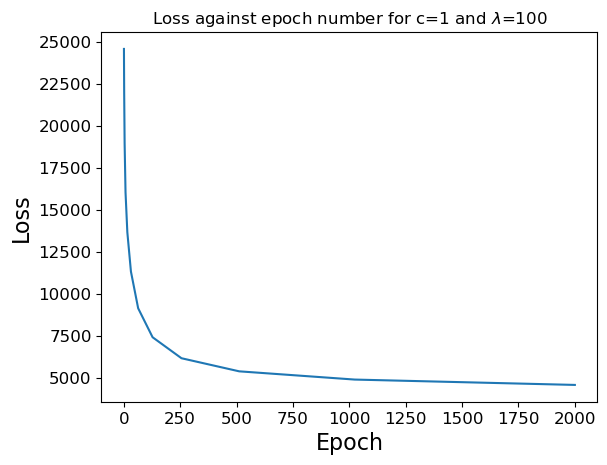

In [18]:
# Obtain weights and lists for plots of loss convergence with the modified Huber function modelling the penalty term
weights_huber, loss_history_huber, iteration_list_huber = mini_batch_gradient_descent_huber(X_train_2_intercept, y_train_2)

# Plot loss against epoch number
plt.plot(iteration_list_huber, loss_history_huber)
plt.title(f'Loss against epoch number for c=1 and $\lambda$=100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Now I define the functions from the SVM lab for mini-batch stochastic gradient descent with the loss function with the penalty term modelled via the hinge function: $max(0, 1 - (\textbf{x}^{(i)} \cdot \textbf{w} + b)$.

In [19]:
# Compute and return the hinge loss function with lambda = 'regul_strength'
def compute_loss_hinge(w, X, y, regul_strength=100.0):
    """
    Compute the loss function for linear SVM.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): Input features.
        y (np.array): Labels.
        regul_strength (float): Regularisation parameter.

    Returns:
        loss (float): Loss function as given by the equation above.

    """

    n = X.shape[0]
    distances = 1 - y * (X @ w)
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = distances.sum()

    # calculate loss
    return 0.5 * np.dot(w, w) + regul_strength * hinge - 0.5 * w[-1] ** 2


# Compute and return the gradient of the hinge loss fucntion with lambda = 'regul_strength'
def calculate_loss_gradient_hinge(w, X_batch, y_batch, regul_strength=100.0):
    """
    Calculate gradient of the hinge loss.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X_batch (np.array): Batch of input features.
        y_batch (np.array): Batch of labels.
        regul_strength (float): Regularisation parameter.

    Returns:
        grad_w (float): Gradient of the modified Huber loss with respect to w.

    """

    # If only one sample is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    we = w.copy() # So as not to overwrite w
    we[-1] = 0

    for ind, d in enumerate(distance):
        if max(0, d) > 0:
            dw += - regul_strength * y_batch[ind] * X_batch[ind]
    dw += we

    dw /= len(y_batch) # average

    return dw


# Perform mini-batch stochastic gradient descent using calculate_loss_gradient_hinge and calculate_loss_hinge to optimise
# and return weights as well as a list of the loss history and a list of the iterations
def mini_batch_gradient_descent_hinge(X, y, batch_size=32, max_iterations=2000, stop_criterion=0.001, learning_rate=1e-4, regul_strength=100.0, print_outcome=False):
    """
    Performs mini-batch stochastic gradient descent to optimise weights.

    Parameters:
        X (np.array): The feature matrix.
        y (np.array): The target labels.
        batch_size (int): Size of each mini-batch.
        max_iterations (int): Maximum number of epochs.
        stop_criterion (float): Percentage change in loss function to determine convergence.
        learning_rate (float): Learning rate for gradient updates.
        regul_strength (float): Regularisation parameter
        print_outcome (bool): Whether to print progress during training.

    Returns:
        weights (np.array): Optimised weights.
        loss_history (list): History of loss.
        iteration_list (list): List of iteration numbers corresponding to the loss values.

    """
    # Initialise weights to zero
    weights = np.zeros(X.shape[1])
    nth = 0
    prev_loss = np.inf  # Initialise starting loss as infinity
    loss_history = []  # Track loss values
    iteration_list = []  # Track iteration numbers

    for iteration in range(1, max_iterations+1):
        # Shuffle data to prevent repeating update cycles
        indices = np.random.permutation(len(y))
        X_shuffled, y_shuffled = X[indices], y[indices]

        # Create mini-batches
        for start_idx in range(0, len(y), batch_size):
            end_idx = start_idx + batch_size
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]

            # Compute the gradient for the mini-batch
            gradient = calculate_loss_gradient_hinge(weights, X_batch, y_batch, regul_strength)

            # Update weights
            weights = weights - (learning_rate * gradient)

        # Check for convergence at 2^nth iteration or last iteration
        if iteration == 2**nth or iteration == max_iterations:
            # Compute the current loss
            loss = compute_loss_hinge(weights, X, y, regul_strength)
            if print_outcome:
                print(f'Iteration: {iteration}, Loss: {loss:.6f}')

            # Check if the stop criterion is met
            if abs(prev_loss - loss) < stop_criterion * prev_loss:
                return weights, loss_history, iteration_list

            # Update tracking variables
            prev_loss = loss
            iteration_list.append(iteration)
            loss_history.append(loss)
            nth += 1

    return weights, loss_history, iteration_list

I apply `mini_batch_gradient_descent_hinge` to our training set to obtain weights and plot the convergence of the loss function, as I did before for the linear soft-margin "Huberised" SVM.

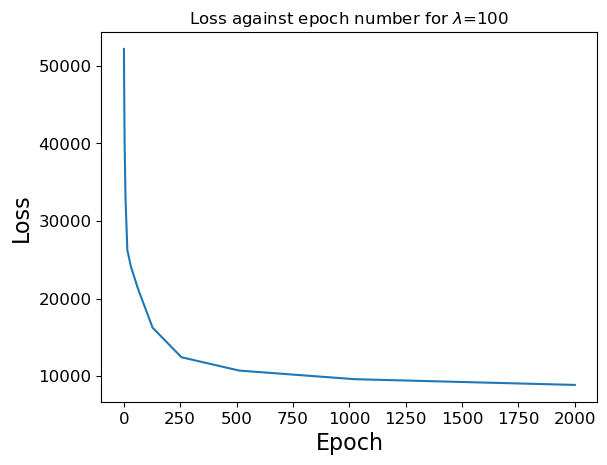

In [20]:
# Obtain weights and lists for plots of hinge loss convergence
weights_hinge, loss_history_hinge, iteration_list_hinge = mini_batch_gradient_descent_hinge(X_train_2_intercept, y_train_2)

# Plot loss against epoch number
plt.plot(iteration_list_hinge, loss_history_hinge)
plt.title(f'Loss against epoch number for $\lambda$=100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

I define `score` from the SVM notebook to compute the mean accuracy of a given set of weights, on a set of data, and also define a new function `margin` to compute the number of training points outside of the margin for given set of weights and data they were trained on.

In [21]:
# Computes the mean accuracy of the weights 'w' on the data 'X', 'y'
def score(w, X, y):
    """
    Computes the mean accuracy.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): The feature matrix.
        y (np.array): The target labels.

    Returns:
        mean_accuracy (np.array): Accuracy score.

    """
    y_preds = np.sign(X @ w)
    mean_accuracy = np.mean(y_preds == y)

    return mean_accuracy


# Computes the number of sample points in 'X', 'y' that fall outside the the margin determined by 'w'
def margin(w, X, y):
    """
    Computes the number of data points in X, 'y' that fall outside the margin.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): The feature matrix of the training data.
        y (np.array): The target labels of the training data.
        
    Returns:
        margin_points (int): Number of points outside the margin.

    """
    A = y * (X @ w)
    margin_points = np.sum(A > 1)
    return margin_points

I now apply score and margin to both of the SVMs and plot the modified Huber function and hinge loss against $yf(x)$.

Huberised SVM test accuracy: 0.9387755102040817
Hinge loss SVM test accuracy: 0.9346938775510204
Number of training data points outside the Huberised SVM margin: 403
Number of training data points outside the Hinge loss SVM margin: 449


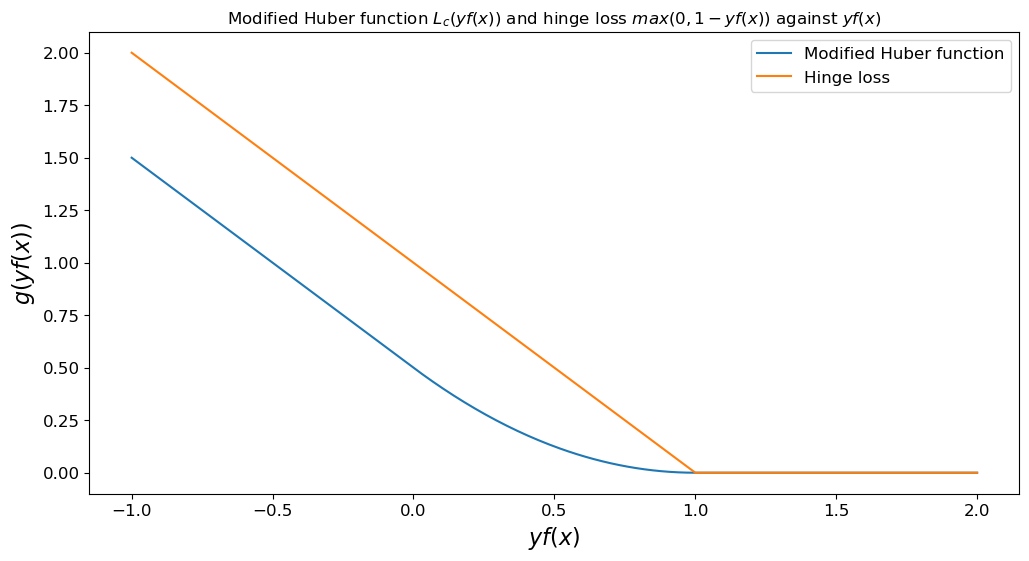

In [22]:
# Compute and print the mean test accuracies of each set of weights as well as the number of training points that fall
# outside the margin
print('Huberised SVM test accuracy:', score(weights_huber, X_test_2_intercept, y_test_2))
print('Hinge loss SVM test accuracy:', score(weights_hinge, X_test_2_intercept, y_test_2))
print('Number of training data points outside the Huberised SVM margin:', margin(weights_huber, X_train_2_intercept, y_train_2))
print('Number of training data points outside the Hinge loss SVM margin:', margin(weights_hinge, X_train_2_intercept, y_train_2))

# Compute the value of the modified Huber function on a range of values from -1 to 2 to plot
x_loss = np.linspace(-1, 2, 400)
z_loss = 1 - x_loss
y_huber = [huber(float(1-x), 1) for x in x_loss]

# Define hinge to calculate the hinge loss of 'z'
def hinge(z):
    return max(0, 1 - z)

# Compute the value of the hinge loss on a range of values from -1 to 2 to plot
y_hinge = [hinge(x) for x in x_loss]

# Plot the modified Huber function and hinge loss from a range of values from -1 to 2
plt.figure(figsize=(12, 6))
plt.plot(x_loss, y_huber, label='Modified Huber function')
plt.plot(x_loss, y_hinge, label='Hinge loss')
plt.title('Modified Huber function $L_c (yf(x))$ and hinge loss $max(0, 1-yf(x))$ against $yf(x)$')
plt.xlabel('$yf(x)$')
plt.ylabel('$g(yf(x))$')
plt.legend()
plt.show()

The "Huberised" SVM has less training points outside of the margin than the SVM with the hinge loss, which is likely due to the modified Huber function having a smaller gradient when $0 < yf(x) < 1$ and being $0.5$ less than the hinge loss for $yf(x) < 0$. The lower gradient means points that are within the margin but still correctly classified are penalised less and this holds more the closer they are to the margin. The lower value for all $yf(x)$ means that all points within the margin will less penalised. These factors ultimately allow for a wider margin and I see from the mean accuracies on the test data that the SVM with the modified Huber function has a slightly better out-of-sample performance than that of the SVM with the hinge loss which is likely due to this "Huberised" SVM having better generalisability since it does not overfit to the data, or at least it overfits to a lesser degree than the SVM with the hinge loss.

<a name="task-22"></a>

## (2.2) [(index)](#index-task-22)

In this section, I carry out 5-fold cross-validation to optimise the paramaters $c$ and $\lambda$ over each distinct pair of hyperparamaters where $c \in \{ 0.5, 1, 10 \}$ and $\lambda \in \{ 1, 100, 10000 \}$. To do this, I first define the functions `cross_val_split` and `cross_val_evaluate_huber` where the former is from the SVM notebook and the latter is adapted from `cross_val_evaluate` in the SVM notebook. I have adapted it so it takes, as an input, a list of pairs of values of the hyperparameters $c$ and $\lambda$ as opposed to just a list of values of $\lambda$.

In [23]:
# Using the number of samples in a data set and the number of folds desired, returns a list of numpy arrays
# containing the indices defining the validation set for one fold
def cross_val_split(num_samples, num_folds):
    """
    Splits the dataset indices into `num_folds` folds for cross-validation.

    Parameters:
        num_samples (int): The total number of samples in the dataset.
        num_folds (int): The number of folds for cross-validation.

    Returns:
        fold (list[np.array]): A list of numpy arrays containing the indices defining the validation set for one fold.
    """

    fold_size = num_samples // num_folds
    shuffled_indices = np.random.permutation(np.arange(num_samples))
    folds = [
        shuffled_indices[k * fold_size : (k + 1) * fold_size]
        for k in range(num_folds)
    ]

    return folds


# Perform T-fold cross-validation on 'data' for each pair of paramaters in 'hyperparameter_pairs' and returns
# two lists, one containing the accuracy on the training set for each hyperparamater pair and the other containing
# the accuracy on the validation set for each hyperparameter pair
def cross_val_evaluate_huber(data, num_folds, hyperparameter_pairs):
    """
    Performs T-fold cross-validation on the given dataset to find the optimal regul_strength.

    Parameters:
        data (np.array): The dataset, where the last column contains the target labels.
        num_folds (int): The number of folds for cross-validation.
        hyperparameter_pairs (list): A list of pairs of hyperparameters c and lambda stored in lists.

    Returns:
        tuple: A tuple containing two lists:
            - train_scores (list): Accuracy scores on the training set for each hyperparameter_pair.
            - val_scores (list): Accuracy scores on the validation set for each hyperparameter_pair..
    """
    folds = cross_val_split(data.shape[0], num_folds)
    train_scores = np.zeros(len(hyperparameter_pairs))
    val_scores = np.zeros(len(hyperparameter_pairs))

    for j, pair in enumerate(hyperparameter_pairs):
        print(f'\nEvaluating pair: c = {pair[0]}, lambda = {pair[1]}')

        for i, val_indices in enumerate(folds):

            # Define the training and validation sets
            train_indices = np.setdiff1d(np.arange(data.shape[0]), val_indices)
            X_train, y_train = data[train_indices, :-1], data[train_indices, -1]
            X_val, y_val = data[val_indices, :-1], data[val_indices, -1]

            # We standardise both training and validation sets
            X_train_std = standardise(X_train)
            X_val_std = standardise(X_val, X_train)

            # Add intercept term (bias) to the feature matrices
            X_train = np.hstack((X_train_std, np.ones((len(X_train_std), 1))))
            X_val = np.hstack((X_val_std, np.ones((len(X_val_std), 1))))

            # Train the model using mini-batch stochastic gradient descent
            weights, _, _ = mini_batch_gradient_descent_huber(
                X_train, y_train,
                regul_strength=pair[1],
                c=pair[0]
            )

            # Evaluate performance on validation set for the corresponding fold
            train_scores[j] += score(weights, X_train, y_train) / num_folds
            val_scores[j] += score(weights, X_val, y_val) / num_folds
        print(f'Training score: {train_scores[j]}')
        print(f'Validation score: {val_scores[j]}')

    return train_scores, val_scores

I now use `cross_val_evaluate_huber` to perform 5-fold cross-validation on each distinct pair of hyperparamaters where $c \in \{ 0.5, 1, 10 \}$ and $\lambda \in \{ 1, 100, 10000 \}$.

In [24]:
# Create the data set which includes both X and y
train_1 = df_train.iloc[:,:7]
train_1.iloc[:,6] = train_1.iloc[:,6].map({0: 1, 1: -1, 2: -1, 3: -1})

# Create the list of pairs of hyperparameters
c_vals, lambda_vals = [0.5, 1, 10], [1, 100, 10000]
pairs = []
for c in c_vals:
    for l in lambda_vals:
        pairs.append([c, l])

# Use cross_val_evaluate_huber to perform 5-fold cross-validation on the pairs of hyperparameters
training_scores, validation_scores = cross_val_evaluate_huber(train_1.to_numpy(), 5, pairs)


Evaluating pair: c = 0.5, lambda = 1
Training score: 0.7299781181619257
Validation score: 0.7228070175438597

Evaluating pair: c = 0.5, lambda = 100
Training score: 0.9474835886214442
Validation score: 0.9438596491228071

Evaluating pair: c = 0.5, lambda = 10000
Training score: 0.9457330415754923
Validation score: 0.9333333333333333

Evaluating pair: c = 1, lambda = 1
Training score: 0.7794310722100657
Validation score: 0.7789473684210526

Evaluating pair: c = 1, lambda = 100
Training score: 0.9470459518599562
Validation score: 0.9368421052631579

Evaluating pair: c = 1, lambda = 10000
Training score: 0.9466083150984683
Validation score: 0.9333333333333333

Evaluating pair: c = 10, lambda = 1
Training score: 0.8087527352297593
Validation score: 0.8035087719298246

Evaluating pair: c = 10, lambda = 100
Training score: 0.9461706783369803
Validation score: 0.9385964912280702

Evaluating pair: c = 10, lambda = 10000
Training score: 0.9334792122538293
Validation score: 0.9245614035087719


From the validation scores in the 5-fold cross-validation it can be seen that $c = 0.5$, $\lambda = 100$ is the optimal pair from the combinations where $c \in \{ 0.5, 1, 10 \}$ and $\lambda \in \{ 1, 100, 10000 \}$ since its accuracy on the validation set is the highest.

Below, I plot the modified Huber function for each value of $c$ considered.

<function matplotlib.pyplot.show(close=None, block=None)>

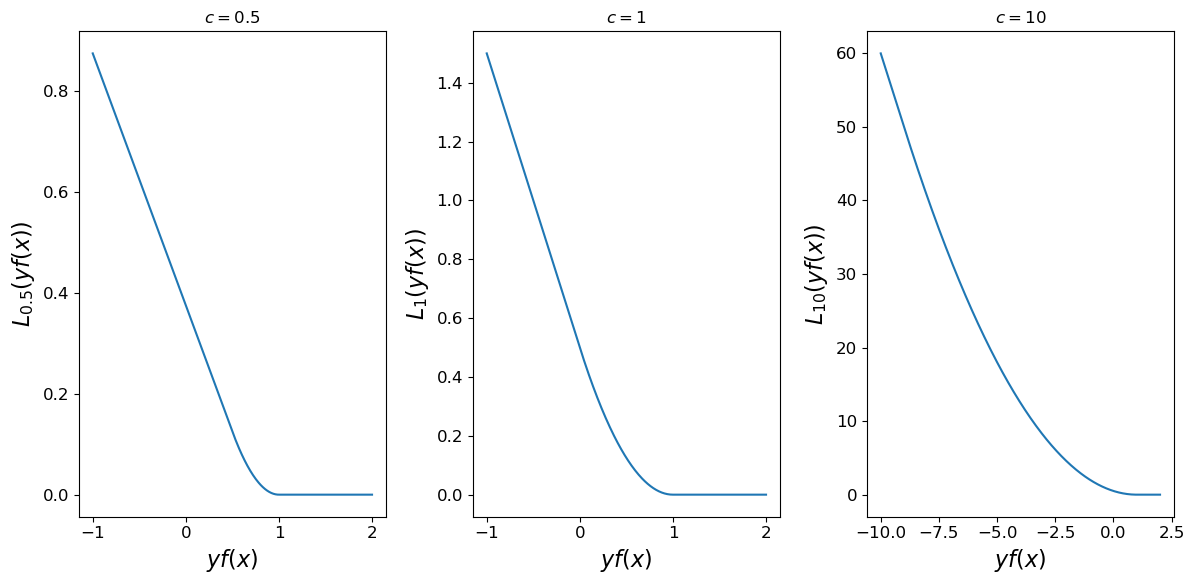

In [25]:
# Create a new array of values of yf(x) for L_10(yf(x))
x_loss_10 = np.linspace(-10, 2, 400)

# Apply the huber function to the appropriate arrays for c = 0.5 and c = 10
y_huber_0 = [huber(float(1-x), 0.5) for x in x_loss]
y_huber_2 = [huber(float(1-x), 10) for x in x_loss_10]

# Plot the function for the three values of c in 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].plot(x_loss, y_huber_0)
axs[0].set_title('$c = 0.5$')
axs[0].set_xlabel('$yf(x)$')
axs[0].set_ylabel('$L_{0.5}(yf(x))$')

axs[1].plot(x_loss, y_huber)
axs[1].set_title('$c = 1$')
axs[1].set_xlabel('$yf(x)$')
axs[1].set_ylabel('$L_{1}(yf(x))$')

axs[2].plot(x_loss_10, y_huber_2)
axs[2].set_title('$c = 10$')
axs[2].set_xlabel('$yf(x)$')
axs[2].set_ylabel('$L_{10}(yf(x))$')

plt.tight_layout()
plt.show

Finally, I train the Huberised SVM with the optimised $c = 0.5$, $\lambda = 100$ on the training data and compute the accuracy on the standardised test set for this SVM as well as the original SVM. I also define the function `score_balanced` to compute the balanced accuracy on the test set for each SVM.

In [26]:
# Computes the balanced accuracy of the weights 'w' on the data 'X', 'y'
def score_balanced(w, X, y):
    """
    Computes the mean accuracy.

    Parameters:
        w (np.array): Vector of weights (incl. bias).
        X (np.array): The feature matrix.
        y (np.array): The target labels where the label is either -1 or 1.

    Returns:
        balanced_accuracy (np.array): Balanced accuracy score.

    """
    y_preds = np.sign(X @ w)
    
    # True Positives and False Negatives for class 1
    TP = np.sum((y_preds == 1) & (y == 1))
    FN = np.sum((y_preds == -1) & (y == 1))
    
    # True Negatives and False Positives for class -1
    TN = np.sum((y_preds == -1) & (y == -1))
    FP = np.sum((y_preds == 1) & (y == -1))
    
    # True positive and true negative rates
    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
    
    # Balanced Accuracy
    balanced_accuracy = (TPR + TNR) / 2

    return balanced_accuracy


# Obtain weights using the optimal values of c and lambda
weights_huber_opt, loss_history_huber_opt, iteration_list_huber_opt = mini_batch_gradient_descent_huber(X_train_2_intercept, y_train_2, regul_strength=100.0, c=0.5)

# Print the test accuracies and balanced test accuracies for the original and optimised Huberised SVMs
print('Original Huberised SVM test accuracy:', score(weights_huber, X_test_2_intercept, y_test_2))
print('Optimised Huberised SVM test accuracy:', score(weights_huber_opt, X_test_2_intercept, y_test_2))
print('Original Huberised SVM balanced test accuracy:', score_balanced(weights_huber, X_test_2_intercept, y_test_2))
print('Optimised Huberised SVM balanced test accuracy:', score_balanced(weights_huber_opt, X_test_2_intercept, y_test_2))

Original Huberised SVM test accuracy: 0.9387755102040817
Optimised Huberised SVM test accuracy: 0.9346938775510204
Original Huberised SVM balanced test accuracy: 0.905693636523885
Optimised Huberised SVM balanced test accuracy: 0.9029613960867267


From these test accuracies and balanced test accuracies, I conclude that the originial SVM trained in [(2.1)](#task-21) actually performs better on the test data set than the SVM with 'optimal' $c$ and $\lambda$, since the original has better accuracy and balanced accuracy. This is due to the fact that each time I train an SVM using `mini_batch_gradient_descent_huber` there is randomness in choosing the mini-batch in each epoch hence I will get a different set of weights each time, even if I use the same hyperparameters. When doing the 5-fold cross-validation, I only trained one SVM per pair of hyperparameters. Hence, in the realisations of the SVMs during cross-validation, the SVM with $c = 0.5$, $\lambda = 100$ had a better accuracy on the test data compared the all other pairs, whereas the SVM I trained above is worse than the original SVM I trained in [(2.1)](#task-21).

<a name="task-3"></a>

# Task 3: Regression with the Multi-Layer Perceptron [(index)](#index-task-3)

In this task, I need to split the training and test data sets into the six features and store these in X and take the 'Runway surface minimal temperature' and 'Runway surface maximal temperature' columns and store these in y. I do this below

In [27]:
# Split training data into X and y and convert to numpy arrays
X_train_3 = df_train.iloc[:,:6].to_numpy()
y_train_3 = df_train.iloc[:,7:9].to_numpy()

# Split test data into X and y and convert to numpy arrays
X_test_3 = df_test.iloc[:,:6].to_numpy()
y_test_3 = df_test.iloc[:,7:9].to_numpy()

<a name="task-31"></a>

## (3.1) [(index)](#index-task-31)

For this section, I define the class `MLP` and its surrounding functions from the MLP notebook, replacing where necessary the mean squared loss and gradient of mean squared loss functions with the new functions I define `compound_loss` and `grad_compound loss` which compute:
$$L = \frac{1}{N^{train}} \sum_{i=1}^{N^{train}}  \big( (T_{min}^{(i)} - \hat{T}_{min}^{(i)})^2 + (T_{max}^{(i)} - \hat{T}_{max}^{(i)})^2 + \lambda max(0, \hat{T}_{min}^{(i)} - \hat{T}_{max}^{(i)}) \big)$$
and 
$$\nabla L = \frac{1}{N_{\text{train}}} \sum_{i=1}^{N_{\text{train}}} \left( 2 (\hat{T}_{\min}^{(i)} - T_{\min}^{(i)}) + \lambda \mathbb{1}(\hat{T}_{\min}^{(i)} > \hat{T}_{\max}^{(i)}), 2 (\hat{T}_{\max}^{(i)} - T_{\max}^{(i)}) - \lambda \mathbb{1}(\hat{T}_{\min}^{(i)} > \hat{T}_{\max}^{(i)}) \right)$$
where $\mathbb{1}(\cdot)$ is the indicator function which is 1 if the inside is true and 0 if it is false.

In [28]:
# Apply the weights W and bias b to X
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in is the input dimension.
        W (np.ndarray): h_out x h_in array for weights matrix parameters, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X])
    return a


# ReLU activation function
def relu_activation(a):
    """ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.maximum(a, 0.)
    return h


# The gradient of the ReLU activation function
def grad_relu_activation(a):
    """Gradient of ReLU activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.zeros_like(a)
    grad[a>0] = 1
    return grad


# A lookup table for activation functions by their names.
activation_table = {
    "relu": relu_activation,
    # Identity function.
    "identity": lambda x: x
}

# A lookup table for gradient of activation functions by their names.
grad_activation_table = {
    "relu": grad_relu_activation,
    # Identity function gradient.
    "identity": lambda x: np.ones_like(x)
}


# Class to represent a MLP
class MLP:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=2):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers (including input and output)."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity"):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function name.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            # hint: use self.rng.normal()
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # store the activation function (as string)
            "activation": activation
        })

    def predict(self, X):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            forward_pass.append({"index": k, "a" : a, "h" : activation(a)})

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # predicted target is output of last layer
        return y_hat, forward_pass

    
# Computes the compound loss between 'y_true' and 'y_pred' with lambda = 'lambd'
def compound_loss(y_true, y_pred, lambd):
    
    T_min_pred = y_pred[:,0]
    T_max_pred = y_pred[:,1]
    T_min_true = y_true[:,0]
    T_max_true = y_true[:,1]
    
    N_train = y_pred.shape[0]
    mse_min = (T_min_pred - T_min_true)**2
    mse_max = (T_max_pred - T_max_true)**2
    loss = np.sum(mse_min + mse_max + lambd * np.maximum(0, T_min_pred - T_max_pred))/N_train
    return loss


# Computes the gradient of the compound loss between 'y_true' and 'y_pred' with lambda = 'lambd'
def grad_compound_loss(y_true, y_pred, lambd):

    T_min_pred = y_pred[:,0]
    T_max_pred = y_pred[:,1]
    T_min_true = y_true[:,0]
    T_max_true = y_true[:,1]
    
    N_train = y_pred.shape[0]
    pos_diff = ((T_min_pred - T_max_pred) > 0).astype(float)
    d_min = (2*(T_min_pred - T_min_true) + lambd * np.sign(T_min_pred - T_max_pred) * pos_diff)/N_train
    d_max = (2*(T_max_pred - T_max_true) - lambd * np.sign(T_min_pred - T_max_pred) * pos_diff)/N_train
    return np.hstack((d_min.reshape(-1, 1), d_max.reshape(-1, 1)))


# Apply backpropagation algorithm
def backpropagate(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        gradients (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric in the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    gradients = []

    # Initialise delta.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):   # zip iterates through pairs of layers and forward_pass
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."

        # Gradients are average gradients over batch
        gradients.append({"W" : (delta.T @ h) / h.shape[0],
                          "b" : delta.mean(axis=0)})

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])


    # Return now ordered list matching the layers.
    gradients = list(reversed(gradients))
    return gradients


# Apply a stochastic gradient descent step using the sampled batch X and y
def sgd_step(X, y, mlp, lambd, learning_rate = 5e-5):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        lambd (float): The chosen lambda to be used in the compound loss function.
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        updated_layers (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X) ## <-- SOLUTION.

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_compound_loss(y, y_hat, lambd)

    # Apply backpropagation algorithm to compute the gradients of the MLP parameters.
    gradients = backpropagate(mlp.layers, forward_pass, delta_output)

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers


# Computes the R^2 score to assess regression performance
def r2_score(y, y_hat):
    """R^2 score to assess regression performance."""

    # Adjustment to avoid subtraction between (K,) and (1, K) arrays.
    y = y.reshape(y_hat.shape)
    y_bar = y.mean()

    ss_tot = ((y - y_bar)**2).sum()
    ss_res = ((y - y_hat)**2).sum()
    return 1 - (ss_res/ss_tot)


# Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
# the training data using Compound loss
def sgd(X_train, y_train, X_test, y_test, mlp, lambd, learning_rate = 5e-5,
        n_epochs=200, minibatchsize=20, seed=2):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using Compound loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        lambd (float): The chosen lambda to be used in the compound loss function.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step(X_batch, y_batch, mlp, lambd, learning_rate)

            # update weights and biases of MLP
            mlp.layers = updated_layers

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(compound_loss(y_train, y_hat_train, lambd).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(compound_loss(y_test, y_hat_test, lambd).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

I now use `MLP` to set up the MLP architecture with $6$ inputs in the input layer, two hidden layers each with $20$ neurons that apply the ReLU activation function and finally an output layer with $2$ neurons for the outcome variables. I then use `sgd` with a learning rate of $5 \times 10^{-5}$, mini-batch size of $20$ for $200$ epochs to train three MLPs, one with $\lambda = 0$, one with $\lambda = 100$ and one with $\lambda = 500$. Finally, I plot the compound loss of each MLP against the number of epochs and compute their respective $R^2$ values on the training and test sets.

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

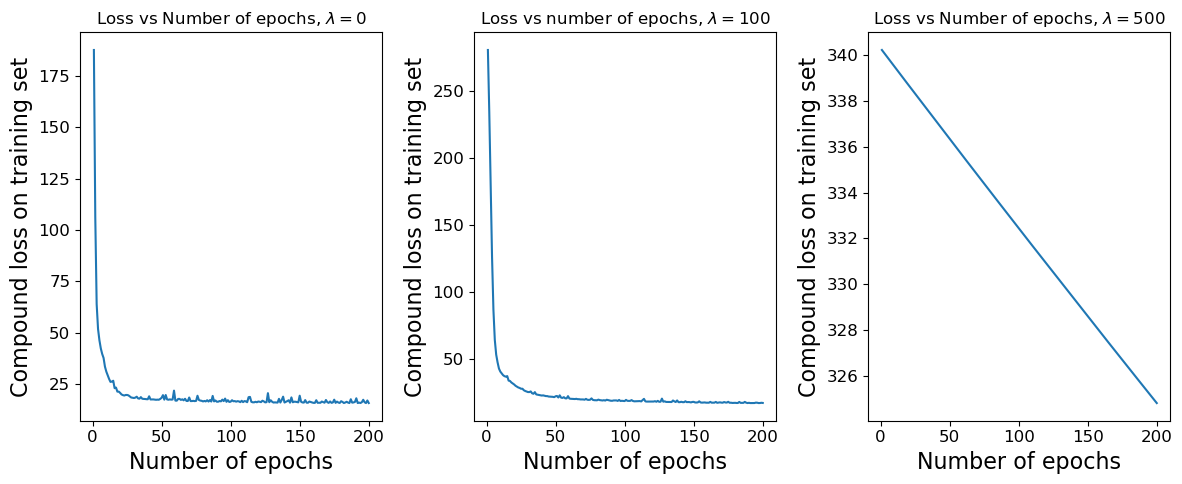

R^2 score of the trained MLP with lambda = 0 on the training data: 0.8162021306612611
R^2 score of the trained MLP with lambda = 0 on the test data: 0.7759301538882055
R^2 score of the trained MLP with lambda = 100 on the training data: 0.7972462887266957
R^2 score of the trained MLP with lambda = 100 on the test data: 0.7632900803523411
R^2 score of the trained MLP with lambda = 500 on the training data: -2.7642362684809356
R^2 score of the trained MLP with lambda = 500 on the test data: -2.907779156117758


In [29]:
# Initialise MLP and train with lambda = 0
mlp = MLP(seed=2)
mlp.add_layer(6, 20)
mlp.add_layer(20, 20, "relu")
mlp.add_layer(20, 2, "relu")
mlp_0, losses_train_0, losses_test_0 = sgd(X_train_3, y_train_3, X_test_3, y_test_3,
                                     mlp, lambd=0.0, learning_rate = 5e-5,
                                     n_epochs=200,
                                     minibatchsize=20)

# Initialise MLP and train with lambda = 100
mlp = MLP(seed=2)
mlp.add_layer(6, 20)
mlp.add_layer(20, 20, "relu")
mlp.add_layer(20, 2, "relu")
mlp_100, losses_train_100, losses_test_100 = sgd(X_train_3, y_train_3, X_test_3, y_test_3,
                                     mlp, lambd=100.0, learning_rate = 5e-5,
                                     n_epochs=200,
                                     minibatchsize=20)

# Initialise MLP and train with lambda = 500
mlp = MLP(seed=2)
mlp.add_layer(6, 20)
mlp.add_layer(20, 20, "relu")
mlp.add_layer(20, 2, "relu")
mlp_500, losses_train_500, losses_test_500 = sgd(X_train_3, y_train_3, X_test_3, y_test_3,
                                     mlp, lambd=500.0, learning_rate = 5e-5,
                                     n_epochs=200,
                                     minibatchsize=20)

# Plot the loss function for each lambda against number of epochs
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax[0].plot(np.arange(1,201), losses_train_0)
ax[1].plot(np.arange(1,201), losses_train_100)
ax[2].plot(np.arange(1,201), losses_train_500)
ax[0].set(title="Loss vs Number of epochs, $\lambda = 0$", xlabel = "Number of epochs", ylabel = "Compound loss on training set")
ax[1].set(title="Loss vs number of epochs, $\lambda = 100$", xlabel = "Number of epochs", ylabel = "Compound loss on training set")
ax[2].set(title="Loss vs Number of epochs, $\lambda = 500$", xlabel = "Number of epochs", ylabel = "Compound loss on training set")
plt.tight_layout()
plt.show()

# Compute and print R^2 value for each MLP on training and test data
print('R^2 score of the trained MLP with lambda = 0 on the training data:', r2_score(y_train_3, mlp_0.predict(X_train_3)[0]))
print('R^2 score of the trained MLP with lambda = 0 on the test data:', r2_score(y_test_3, mlp_0.predict(X_test_3)[0]))
print('R^2 score of the trained MLP with lambda = 100 on the training data:', r2_score(y_train_3, mlp_100.predict(X_train_3)[0]))
print('R^2 score of the trained MLP with lambda = 100 on the test data:', r2_score(y_test_3, mlp_100.predict(X_test_3)[0]))
print('R^2 score of the trained MLP with lambda = 500 on the training data:', r2_score(y_train_3, mlp_500.predict(X_train_3)[0]))
print('R^2 score of the trained MLP with lambda = 500 on the test data:', r2_score(y_test_3, mlp_500.predict(X_test_3)[0]))

Looking at the plots of the compound loss function on the training set against the number of epochs for each value of $\lambda$, it is seen that for $\lambda = 0$ and $\lambda = 100$ the training does not take too many epochs to converge as the compound loss function is quite steady after 25 epochs. However, for $\lambda = 500$ the compound loss decreases linearly as number of epochs increases and only decreases by about $5$% of the initial loss after 200 epochs.

Now, looking at the $R^2$ values on the training and test data sets for each $\lambda$ it can be seen that $\lambda = 0$ achieves the highest $R^2$ on both the training and test data sets followed closely by $\lambda = 100$ for both data sets and $\lambda = 500$ has negative $R^2$ values on both data sets. From this I conclude $\lambda = 0$ performs the best, $\lambda = 100$ performs slightly worse and $\lambda = 500$ does not capture the relationships in the data at all.

Looking at the loss function 
$$L = \frac{1}{N^{train}} \sum_{i=1}^{N^{train}}  \big( (T_{min}^{(i)} - \hat{T}_{min}^{(i)})^2 + (T_{max}^{(i)} - \hat{T}_{max}^{(i)})^2 + \lambda max(0, \hat{T}_{min}^{(i)} - \hat{T}_{max}^{(i)}) \big)$$
I see that it is composed of two parts: the sum of the mean squared errors for $\hat{T}_{min}^{(i)}$ and $\hat{T}_{max}^{(i)}$ and the hyperparameter $\lambda$ multiplied by $\hat{T}_{min}^{(i)} - \hat{T}_{max}^{(i)}$ if $\hat{T}_{min}^{(i)} > \hat{T}_{max}^{(i)}$. When $\lambda = 0$, the loss is just the sum of the two mean squared errors hence the MLP will optimise freely aiming to just minimise these errors, however when $\lambda > 0$ the additional penalty term enforces the MLP to adhere to the constraint $\hat{T}_{min}^{(i)} \leq \hat{T}_{max}^{(i)}$. Hence, for the MLPs with $\lambda = 100$ and $\lambda = 500$ the performance of the MLP is worsened as they are required to adhere to this logical constraint (as the minimal temperature should be less than or equal to the maximal temperature), however the performance loss is minimal for $\lambda = 100$ but the loss function is dominated by this second term for $\lambda = 500$ and the MLP is useless.

<a name="task-32"></a>

## (3.2) [(index)](#index-task-32)

In this final section, I implement a deep MLP with and without dropout. To do so, I adapt the class `MLP` so that the `add_layer` method in `MLP_dropout` takes another input 'dropout_rate' which is set to $0$ if not specified and the `predict` method in `MLP_dropout` takes another input 'training' which is set to False. When 'training' is set to true which it is in `sgd_step_dropout` only, `predict` will randomly remove neurons in every layer with the dropout rate specified in that layer and will add the mask used to remove neurons to the dictionary 'forward_pass'. `backpropagate_dropout` is altered to only update the neurons that were not removed in the forward pass.`sgd_step_dropout` and `sgd_dropout` are then only altered to implement these new methods of `MLP_dropout` and `backpropagate_dropout` correctly.

In [30]:
# Altered MLP with changes to 'add_layer' and 'predict'
class MLP_dropout:
    """
    This class represents a Multi-Layer Perceptron (MLP), that we are going
    to use to encapsulate two components:
        1. layers: the sequence of layers, where each layer is stored in
            a dictionary in the format {"W": np.ndarray, "b": np.ndarray},
            where "W" points to the weights array, and "b" points to
            the bias vector.
        2. rng: a pseudo random number generator (RNG) initialised to generate
            the random weights in a reproducible manner between different
            runtime sessions.
    This class is also shipped with methods that perform essential operations
    with a MLP, including:
        - add_layers: which creates a new layer with specified dimensions.
        - predict: applies the MLP forward pass to make predictions and produces
            a computational graph for the forward pass that can be used to
            compute gradients using backpropagation algorithm.
        in addition to other light functions that return simple statistics about
        the MLP.
    """
    def __init__(self, seed=2):
        self.layers = []
        self.rng = np.random.default_rng(seed)

    def n_parameters(self):
        """Return the total number of parameters of weights and biases."""
        return sum(l["b"].size + l["W"].size for l in self.layers)

    def n_layers(self):
        """Return current number of MLP layers (including input and output)."""
        return len(self.layers) + 1 if len(self.layers) > 0 else 0

    def layer_dim(self, index):
        """Retrieve the dimensions of the MLP layer at `index`."""
        return self.layers[index]["W"].shape

    def add_layer(self, in_dim, out_dim, activation="identity", dropout_rate=0.0):
        """Add fully connected layer to MLP.

        Parameters:
            in_dim (int): The input dimension of the layer.
            out_dim (int): The output dimension of the layer.
            activation (str): The activation function name.
            dropout_rate (float): The dropout rate.
        """
        # check if input-dimension matches output-dimension of previous layer
        if self.n_layers() > 0:
            last_out_dim, _ = self.layer_dim(-1)
            assert in_dim == last_out_dim, f"Input-dimension {in_dim} does not match output-dimension {last_out_dim} of previous layer."

        # the first layer, in our convention illustrated, does not apply activation on the input features X.
        if self.n_layers() == 0:
            assert activation == "identity", "Should not apply activations on the input features X, use Identity function for the first layer."


        # store each layer as a dictionary in the list, as shown in the
        # attached diagram.
        self.layers.append({
            # only for debugging.
            "index": len(self.layers),
            # apply Glorot initialisation for weights.
            "W": self.rng.normal(size=(out_dim, in_dim)) * np.sqrt(2. / (in_dim + out_dim)),
            # initialise bias vector with zeros.
            "b": np.zeros(out_dim),
            # store the activation function (as string)
            "activation": activation,
            # Now also store the dropout rate (UPDATED)
            "dropout_rate": dropout_rate
        })

    def predict(self, X, training=False):
        """Apply the forward pass on the input X and produce prediction and the
        forward computation graph.

        Parameters:
            X (np.ndarray): Feature matrix.

        Returns:
            (np.ndarray, List[Dict[str, np.ndarray]]): A tuple of the
            predictions and the computation graph as a sequence of intermediate
            values through the MLP, specifically each layer will have a corresponding
            intermediate values {"a": np.ndarray, "h": np.ndarray}, as shown in the
            attached diagram above.
        """
        # We assume that we work with a batch of examples (ndim==2).
        if X.ndim == 1:
            # If one example passed, add a dummy dimension for the batch.
            X = X.reshape(1, -1)

        # store pre- and post-activations in list
        forward_pass = [{"index": 0, "a": X, "h": X}]

        # iterate through hidden layers
        for k in range(1, len(self.layers)):
            # compute pre-activations
            a = dense(forward_pass[k - 1]["h"], self.layers[k - 1]["W"], self.layers[k - 1]["b"])
            activation = activation_table[self.layers[k]["activation"]]
            h = activation(a)
            
            # Implement the dropout to randomly remove neurons with rate 'dropout_rate' for layer k (UPDATED)
            if training:
                dropouts = (self.rng.random(h.shape) > self.layers[k]["dropout_rate"]).astype(float)
                h = h * dropouts / (1 - self.layers[k]["dropout_rate"]) # Scale to keep expectation same
                
            forward_pass.append({"index": k, "a" : a, "h" : h})
            
            # Add the mask 'dropouts' to the forward_pass dictionary to be used in backpropagate (UPDATED)
            if training:    
                forward_pass[-1]["dropouts"] = dropouts

        y_hat = dense(forward_pass[-1]["h"], self.layers[-1]["W"], self.layers[-1]["b"])
        # predicted target is output of last layer
        return y_hat, forward_pass
    
    
# Altered 'backpropagate' to only alter neurons that were included in the forward pass
def backpropagate_dropout(layers, forward_pass, delta_output):
    """
    Apply the backpropagation algorithm to the MLP layers to compute the gradients starting from
    the output layer to the input layer, and starting the chain rule from the
    partial derivative of the loss function w.r.t the predictions $\hat{y}$

    Parameters:
        layers (List[Dict[str, np.ndarray]]): The MLP sequence of layers, as shown in the diagrams.
        forward_pass (List[Dict[str, np.ndarray]]): The forward pass intermediate values for
            each layer, representing a computation graph.
        delta_output (np.ndarray): the partial derivative of the loss function w.r.t the
            predictions $\hat{y}$, has the shape (K, 1), where K is the batch size.
    Returns:
        gradients (List[Dict[str, np.ndarray]]): The computed gradient using a structure symmetric in the layers, as shown
            in the diagrams.

    """
    # Create a list that will contain the gradients of all the layers.
    gradients = []

    # Initialise delta.
    delta = delta_output

    assert len(layers) == len(forward_pass), "Number of layers is expected to match the number of forward pass layers"

    # Iterate on layers backwardly, from output to input.
    # Calculate gradients w.r.t. weights and biases of each level and store in list of dictionaries.
    for layer, forward_computes in reversed(list(zip(layers, forward_pass))):   # zip iterates through pairs of layers and forward_pass
        assert forward_computes["index"] == layer["index"], "Mismatch in the index."

        h = forward_computes["h"]
        assert delta.shape[0] == h.shape[0], "Mismatch in the batch dimension."

        # Gradients are average gradients over batch
        gradients.append({"W" : (delta.T @ h) / h.shape[0],
                          "b" : delta.mean(axis=0)})

        # Update the delta for the next iteration
        grad_activation_f = grad_activation_table[layer["activation"]]
        grad_activation = grad_activation_f(forward_computes["a"])

        # Calculate the delta for the backward layer.
        delta = np.stack([np.diag(gi) @ layer["W"].T @ di
                           for (gi, di) in zip(grad_activation, delta)])
        
        # Only update neurons that remain after dropout (UPDATED)
        if "dropouts" in forward_computes:
            delta = delta * forward_computes["dropouts"]

    # Return now ordered list matching the layers.
    gradients = list(reversed(gradients))
    return gradients


# Altered 'sgd_step' to now set training = True, and set dropout rate in updated layers
def sgd_step_dropout(X, y, mlp, lambd, learning_rate = 5e-5):
    """
    Apply a stochastic gradient descent step using the sampled batch.
    Parameters:
        X (np.ndarray): The input features array batch, with dimension (K, p).
        y (np.ndarray): The ground-truth of the batch, with dimension (K, 1).
        lambd (float): The chosen lambda to be used in the compound loss function.
        learning_rate (float): The learning rate multiplier for the update steps in SGD.
    Returns:
        updated_layers (List[Dict[str, np.ndarray]]): The updated layers after applying SGD.
    """
    # Compute the forward pass.
    y_hat, forward_pass = mlp.predict(X, training=True) # training = True (UPDATED)

    # Compute the partial derivative of the loss w.r.t. to predictions `y_hat`.
    delta_output = grad_compound_loss(y, y_hat, lambd)

    # Apply new backpropagate_dropout function to compute the gradients of the MLP parameters (UPDATED)
    gradients = backpropagate_dropout(mlp.layers, forward_pass, delta_output)

    # mlp.layers and gradients are symmetric, as shown in the figure.
    updated_layers = []
    for layer, grad in zip(mlp.layers, gradients):
        W = layer["W"] - learning_rate * grad["W"]
        b = layer["b"] - learning_rate * grad["b"]
        updated_layers.append({"W": W, "b": b,
                               # keep the activation function.
                               "activation": layer["activation"],
                               # Also keep the dropout rate (UPDATED)
                               "dropout_rate": layer["dropout_rate"],
                               # We use the index for asserts and debugging purposes only.
                               "index": layer["index"]})
    return updated_layers



# Altered 'sgd' to now use 'sgd_step_dropout'
def sgd_dropout(X_train, y_train, X_test, y_test, mlp, lambd, learning_rate = 5e-5,
        n_epochs=200, minibatchsize=20, seed=2):
    """
    Run the Stochastic Gradient Descent (SGD) algorithm to optimise the parameters of MLP model to fit it on
    the training data using Compound loss.

    Parameters:
        X_train (np.ndarray): The training data features, with shape (N^{training}, p).
        y_train (np.ndarray): The training data ground-truth, with shape (N^{training}, 1).
        X_test (np.ndarray): The testing data features, with shape (N^{test}, p).
        y_test (np.ndarray): The testing data ground-truth, with shape (N^{test}, 1).
        mlp (MLP): The MLP object enacpsulating the MLP model.
        lambd (float): The chosen lambda to be used in the compound loss function.
        learning_rate (float): The learning_rate multiplier used in updating the parameters at each iteration.
        n_epochs (int): The number of training cycles that each covers the entire training examples.
        minibatchsize (int): The batch size used in each SGD step.
        seed (int): A seed for the RNG to ensure reproducibility across runtime sessions.

    Returns:
        mlp (MLP): MLP object encapuslating the trained MLP model.
        losses_train (np.ndarray): Train losses over epochs.
        losses_tset (np.ndarray): Test losses over epochs.
    """

    # get random number generator
    rng = np.random.default_rng(seed)

    # compute number of iterations per epoch
    n_iterations = int(len(y_train) / minibatchsize)

    # store losses
    losses_train = []
    losses_test = []

    epochs_bar = tqdm(range(n_epochs))
    for i in epochs_bar:

        # shuffle data
        p = rng.permutation(len(y_train))
        X_train_shuffled = X_train[p]
        y_train_shuffled = y_train[p]

        for j in range(n_iterations):
            # get batch
            X_batch = X_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]
            y_batch = y_train_shuffled[j*minibatchsize : (j+1)*minibatchsize]

            # apply sgd step
            updated_layers = sgd_step_dropout(X_batch, y_batch, mlp, lambd, learning_rate) # Use new 'sgd_step_dropout' (UPDATED)

            # update weights and biases of MLP
            mlp.layers = updated_layers

        # compute loss at the end of each epoch
        y_hat_train, _ = mlp.predict(X_train)
        losses_train.append(compound_loss(y_train, y_hat_train, lambd).squeeze())
        y_hat_test, _ = mlp.predict(X_test)
        losses_test.append(compound_loss(y_test, y_hat_test, lambd).squeeze())
        epochs_bar.set_description(f'train_loss: {losses_train[-1]:.2f}, '
                                   f'test_loss: {losses_test[-1]:.2f}, '
                                   f'train_R^2: {r2_score(y_train, y_hat_train):.2f} '
                                   f'test_R^2: {r2_score(y_test, y_hat_test):.2f} ')
    return mlp, losses_train, losses_test

Now I have implemented these changes, I train an MLP with $\lambda = 0$ and the network architecture as follows: an input layer of the six features, five hidden layers with $100$, $200$, $300$, $100$ and $100$ neurons each, followed by the output layer with two neurons, the outcome variables. All hidden layers apply the ReLU activation function. I apply dropout with rate $0.1$ in the $4^{th}$ hidden layer and use `sgd_dropout` with a learning rate of $5 \times 10^{-5}$, mini-batch size of $16$ to train the network for $200$ epochs. I train another MLP with the same learning rate, mini-batch size and network architecture for $200$ epochs without the dropout in the $4^{th}$ hidden layer for comparison. Then, I plot the training and test losses for each MLP against the number of epochs in a plot for each MLP.

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

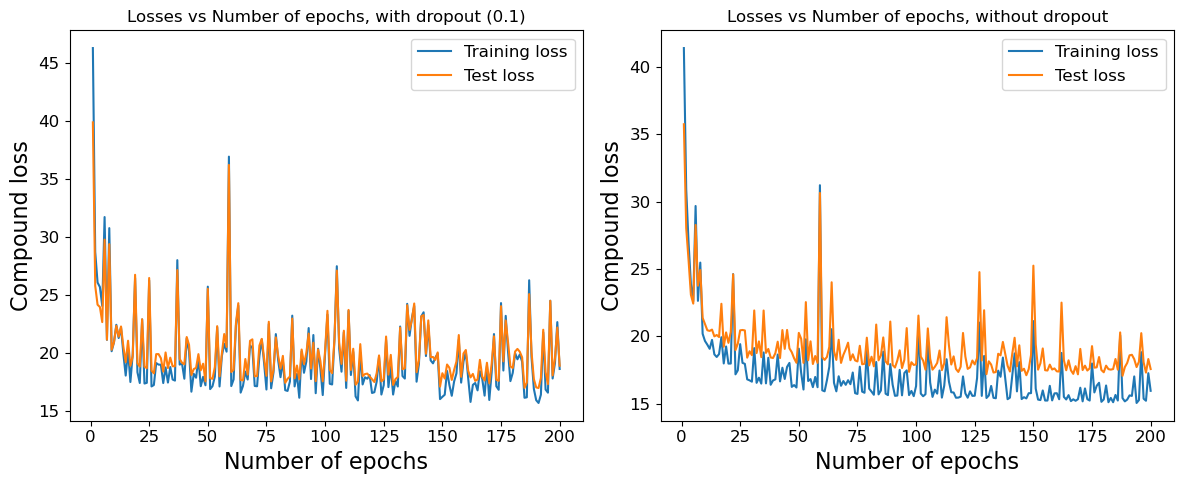

In [31]:
# Initialise the MLP with dropout
mlp = MLP_dropout(seed=2)
mlp.add_layer(6, 100)
mlp.add_layer(100, 200, "relu")
mlp.add_layer(200, 300, "relu")
mlp.add_layer(300, 100, "relu")
mlp.add_layer(100, 100, "relu", dropout_rate=0.1)
mlp.add_layer(100, 2, "relu")

# Train the MLP with dropout
mlp_dropout, losses_train_dropout, losses_test_dropout = sgd_dropout(X_train_3, y_train_3, X_test_3, y_test_3,
                                     mlp, lambd=0.0, learning_rate = 5e-5,
                                     n_epochs=200,
                                     minibatchsize=16)

# Initialise the MLP without dropout
mlp = MLP_dropout(seed=2)
mlp.add_layer(6, 100)
mlp.add_layer(100, 200, "relu")
mlp.add_layer(200, 300, "relu")
mlp.add_layer(300, 100, "relu")
mlp.add_layer(100, 100, "relu")
mlp.add_layer(100, 2, "relu")

# Train the MLP without dropout
mlp_nondropout, losses_train_nondropout, losses_test_nondropout = sgd_dropout(X_train_3, y_train_3, X_test_3, y_test_3,
                                     mlp, lambd=0.0, learning_rate = 5e-5,
                                     n_epochs=200,
                                     minibatchsize=16)

# Plot the training and test loss for each MLP against number of epochs
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(np.arange(1,201), losses_train_dropout, label="Training loss")
ax[0].plot(np.arange(1,201), losses_test_dropout, label="Test loss")
ax[0].legend()
ax[0].set(title="Losses vs Number of epochs, with dropout (0.1)", xlabel = "Number of epochs", ylabel = "Compound loss")
ax[1].plot(np.arange(1,201), losses_train_nondropout, label="Training loss")
ax[1].plot(np.arange(1,201), losses_test_nondropout, label="Test loss")
ax[1].legend()
ax[1].set(title="Losses vs Number of epochs, without dropout", xlabel = "Number of epochs", ylabel = "Compound loss")
plt.tight_layout()
plt.show()

Finally, for each MLP I plot a histogram of the post-activations of the $4^{th}$ hidden layer.

<function matplotlib.pyplot.show(close=None, block=None)>

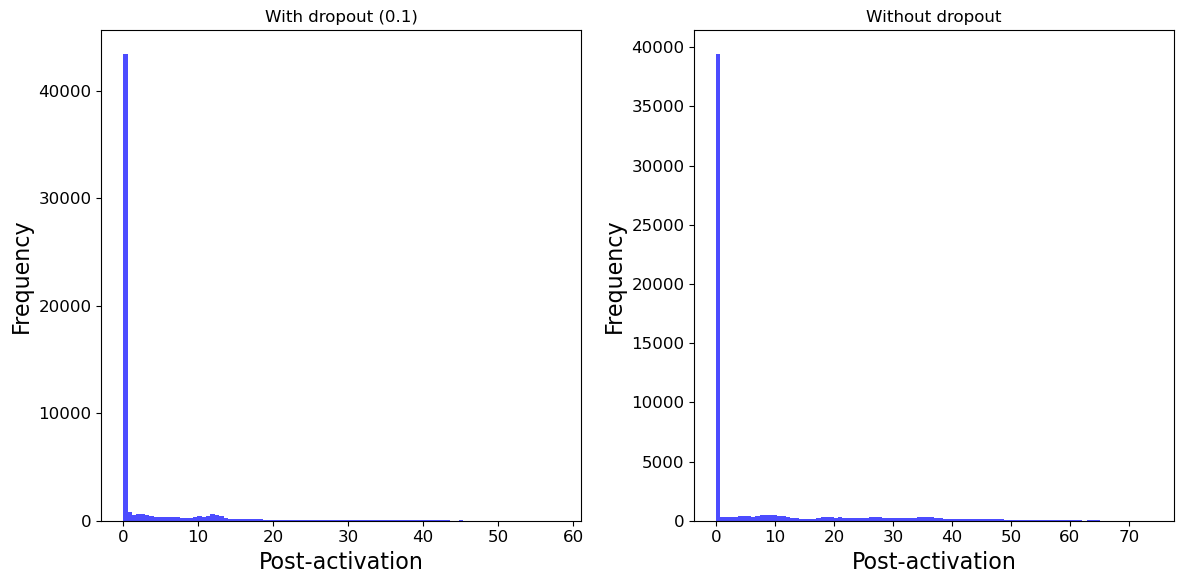

In [32]:
# Do a forward pass of each MLP with training = True for the MLP with dropout
_, fp_dropout = mlp_dropout.predict(X_train_3, training=True)
_, fp_nondropout = mlp_nondropout.predict(X_train_3)

# Get the post-activations of the 4th hidden layer and flatten them
h_4_dropout = fp_dropout[4]["h"].flatten()
h_4_nondropout = fp_nondropout[4]["h"].flatten()

# Plot the two histograms
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].hist(h_4_dropout, bins=100, color='blue', alpha=0.7)
axs[0].set_title('With dropout (0.1)')
axs[0].set_xlabel('Post-activation')
axs[0].set_ylabel('Frequency')

axs[1].hist(h_4_nondropout, bins=100, color='blue', alpha=0.7)
axs[1].set_title('Without dropout')
axs[1].set_xlabel('Post-activation')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show

From the figure of the losses on the training and test data against the number of epochs, it can be seen that the MLP with dropout generalises very well onto the test data as the loss on the test set is always very close to the loss on the training data. Comparing this to the plot for the MLP without dropout there is a much bigger diference between the losses on the training and test data for this MLP without dropout, hence there is clearly some overfitting to the training data since loss is consistently larger on the test data. Looking at the values of the loss however, I see that the MLP with dropout has slightly greater loss on the test set than the MLP without dropout across the range of epochs. The reason for the first observation is that dropout acts as regularisation and prevents the MLP from overfitting to the training data, hence it has training loss and test loss almost identical for the majority of epochs. Since the MLP without dropout does not experience this regularisation the overfitting to the training data is what can be seen in the difference between training and test losses. The reason for the second observation is down to the way that dropout deactivates neurons on each epoch which means the MLP is not able to minimise loss as efficiently as the MLP without dropout, hence the MLP with dropout has larger loss on both the training and test set.

Looking at the histograms of the post-activations of the $4^{th}$ hidden layer, there is a small increase in the number of post-activations of value $0$ in the MLP with dropout. The reason for the greater number of $0$ value post-activations is the implementation of dropout with $0.1$ will cause around $10$% of the neurons to be set to $0$.